# Variation with microbiome composition (Figure 3)

This script estimates the variation of FP excretion across different microbiome samples. To estimate this variation it takes abundance data from the curated metagenomics dataset from the Waldron lab (https://waldronlab.io/curatedMetagenomicData/index.html) and considers the relative abundance of the different experimentally characterized strains.

In [9]:
#load required packages
import pandas as pd
import subprocess
import numpy as np
import json
import os, sys
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from datetime import datetime
import numpy as np
import json
import time
from matplotlib import rc_file
from pylab import *
import json

#read in basic characteristics of British reference diet
with open('data_analysisresults/BRD_characteristics.json', 'r') as fp:
        BRD = json.load(fp)



with open('data_analysisresults/average_excretion/av_YCA.json', 'r') as fp:
        avexcretion_YCA = json.load(fp)


# variation of fp secretion with microbiome composition and health status
Disscussion Markus/Jonas after variation analysis, November 2023
- huge study to study variation but different groups within the same study (e.g. healthy vs IBD) show often very similar behavior with means often exactly matching
- no significant changes with age except for butyrate excretio which is clearly lower in infants (as expected)
- strong change in lactate vs propionate/succinate production when comparing Western vs non-Western samples (as defined in the curated metagenomics dataset)

Conclusion: 
- need in study comparisons and proper statistics.
- for RC's paper: remove iBD (or massiviely increase sample size and criticially evaluate). Possible nice point for change of butyrate/propionate with age by comparison with ourpredictions. Also, need to probe for possible trends WITHIN studies.

# Load measured yield data

In [10]:
#read information on experimentally characterized species
speciesinformation=pd.read_csv("data_hplc/species_properties.csv",skiprows=1)
characterized_species=speciesinformation["species"].tolist()

#print(df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
print(speciesinformation["species"])
#ll

#yieldresults (yields and excretion, here still in unites of mmol/OD l)
yieldresults=pd.read_csv("data_hplc/hplc_majorresults.csv")
#select data for which medium to use
yieldresults=yieldresults.loc[yieldresults["medium"]=="YCA"]

#merge yield information to species information
speciesinformation=speciesinformation.merge(yieldresults,left_on="species_HPLCname",right_on="species")
speciesinformation["species"] = speciesinformation['species_x']


display(speciesinformation.columns)
display(speciesinformation)

speciesinformation_taxonomiclevel=[]
taxlevels=["species","genus","family","order","class","phylum"]
taxlevels_names_characterized=[]
for taxlevel in taxlevels:
    speciesinformation_taxonomiclevel.append(speciesinformation.groupby(taxlevel).mean(numeric_only=True))
    display(speciesinformation_taxonomiclevel[-1])
    taxlevels_names_characterized.append(speciesinformation_taxonomiclevel[-1].index)


#plotting settings
sublist=['glucose','maltose','acetate','butyrate','formate','lactate','propionate','succinate']
sublist_color=['#5d5d5d','#BBBBBB','#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

sublist_secretion=sublist[2:]
#sublist_color=['b','b','#1b9e77','#66a61e','#a6761d','#e7298a','#d95f02','#7570b3']
#sublist_color = met_brewer.met_brew(name="Egypt", n=8, brew_type="continuous")
#sublist_color=['#dd5129', '#85635d', '#2c7591', '#34a28d', '#fab255','#5db27d', '#1e8b99','#acb269']

sublist_color_secretion=sublist_color[2:]
sublist_energy=[0.68,1.36,0.21,0.52,0.,.33,0.37,0.36]
sublist_energy_secretion=sublist_energy[2:]

#conversion factor 
conversionfactorOD=0.5 #to go from mM/OD to mmol/g (1 OD l = 0.5 g)

average_uptake_secretion=pd.read_csv("data_analysisresults/secretion_microbiomestudies.csv",index_col=0)
display(average_uptake_secretion.head())

display(average_uptake_secretion.columns.values)

#information about samples from curated metagenomics data
colnames=pd.read_csv("data_curated_microbiome/relabundance_colData.csv")
colnames.rename(columns={'Unnamed: 0': 'sample'},inplace=True)
display(colnames.head(3))
display(colnames.shape)

0               Bacteroides uniformis
1                Bacteroides fragilis
2                  Bacteroides ovatus
3        Bacteroides thetaiotaomicron
4              Bacteroides finegoldii
5                Phocaeicola vulgatus
6                    Prevotella copri
7          Parabacteroides distasonis
8              Roseburia intestinalis
9                 Eubacterium rectale
10                Lachnospira eligens
11                  Dorea longicatena
12    Fusicatenibacter saccharivorans
13                   Blautia wexlerae
14          Blautia hydrogenotrophica
15       Faecalibacterium prausnitzii
16                Eubacterium siraeum
17                Ruminococcus bromii
18             Bifidobacterium longum
19       Bifidobacterium adolescentis
20            Collinsella aerofaciens
21                   Escherichia coli
Name: species, dtype: object


Index(['species_HPLCname', 'species_x', 'new_species', 'species.1',
       'species_short', 'new_genus', 'genus', 'new_family', 'family',
       'new_order', 'order', 'new_class', 'class', 'new_phylum', 'phylum',
       'Unnamed: 0', 'species_y', 'glucose', 'acetate', 'propionate',
       'succinate', 'lactate', 'butyrate', 'formate', 'maltose', 'medium',
       'species'],
      dtype='object')

,species_HPLCname,species_x,new_species,species.1,species_short,new_genus,genus,new_family,family,new_order,...,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose,medium,species
0,B.uniformis,Bacteroides uniformis,Bacteroides uniformis,Bacteroides uniformis,B. uniformis,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,...,-6.650701,3.610049,0.292439,3.280870e-16,10.845330,0.009401,4.765271,0.000000,YCA,Bacteroides uniformis
1,B.fragilis,Bacteroides fragilis,Bacteroides fragilis,Bacteroides fragilis,B. fragilis,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,...,-4.832237,3.496001,0.380547,2.658095e+00,0.499204,0.000000,2.187005,0.000000,YCA,Bacteroides fragilis
2,B.ovatus,Bacteroides ovatus,Bacteroides ovatus,Bacteroides ovatus,B. ovatus,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,...,-4.210851,8.802434,0.306027,1.523860e+00,0.307526,0.014638,10.289419,0.000000,YCA,Bacteroides ovatus
3,B.theta,Bacteroides thetaiotaomicron,Bacteroides thetaiotaomicron,Bacteroides thetaiotaomicron,B. theta,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,...,-6.248500,4.504513,1.518513,2.332290e+00,0.728622,0.000000,0.925419,0.000000,YCA,Bacteroides thetaiotaomicron
4,B.finegoldii,Bacteroides finegoldii,Bacteroides finegoldii,Bacteroides finegoldii,B. finegoldii,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,...,-4.654721,3.666919,0.999781,2.024829e+00,0.110719,0.014567,1.813101,0.000000,YCA,Bacteroides finegoldii
5,B.vulgatus,Phocaeicola vulgatus,Phocaeicola vulgatus,Bacteroides vulgatus,B. vulgatus,Phocaeicola,Phocaeicola,Bacteroidaceae,Bacteroidaceae,Bacteroidales,...,-5.365080,4.885603,0.627039,3.538685e+00,0.087761,0.000000,2.497726,0.000000,YCA,Phocaeicola vulgatus
6,P.copri,Prevotella copri,Prevotella copri,Prevotella copri,P. copri,Prevotella,Prevotella,Prevotellaceae,Prevotellaceae,Bacteroidales,...,-8.366688,4.894400,0.156131,2.300822e-16,12.054598,0.037772,5.919670,0.000000,YCA,Prevotella copri
7,P.distastonis,Parabacteroides distasonis,Parabacteroides distasonis,Bacteroides distasonis,P. distastonis,Parabacteroides,Parabacteroides,Tannerellaceae,Tannerellaceae,Bacteroidales,...,-5.080898,2.790486,1.174451,2.204980e+00,0.188702,0.033736,1.513597,0.000000,YCA,Parabacteroides distasonis
8,R.intestinalis,Roseburia intestinalis,Roseburia intestinalis,Roseburia intestinalis,R. intestinalis,Roseburia,Roseburia,Lachnospiraceae,Lachnospiraceae,Eubacteriales,...,-5.271650,3.204623,1.135440,1.358149e-01,0.003852,2.923401,1.280115,0.000000,YCA,Roseburia intestinalis
9,E.rectale,Eubacterium rectale,Agathobacter rectalis,Eubacterium rectale,E. rectale,Agathobacter,Lachnospiraceae_NA,Lachnospiraceae,Lachnospiraceae,Eubacteriales,...,-6.572609,2.868648,0.729635,5.716495e-02,0.069866,3.887095,1.014707,0.000000,YCA,Eubacterium rectale


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
species,,,,,,,,,
Bacteroides finegoldii,165.0,-4.654721,3.666919,0.999781,2.024829e+00,0.110719,0.014567,1.813101,0.000000
Bacteroides fragilis,167.0,-4.832237,3.496001,0.380547,2.658095e+00,0.499204,0.000000,2.187005,0.000000
Bacteroides ovatus,175.0,-4.210851,8.802434,0.306027,1.523860e+00,0.307526,0.014638,10.289419,0.000000
Bacteroides thetaiotaomicron,178.0,-6.248500,4.504513,1.518513,2.332290e+00,0.728622,0.000000,0.925419,0.000000
Bacteroides uniformis,182.0,-6.650701,3.610049,0.292439,3.280870e-16,10.845330,0.009401,4.765271,0.000000
Bifidobacterium adolescentis,163.0,-8.238885,12.114113,2.233406,5.445836e-01,3.221920,0.000000,0.998964,0.000000
Bifidobacterium longum,172.0,-9.243031,13.612177,1.578880,4.546007e-01,3.149715,0.000000,1.157540,0.000000
Blautia hydrogenotrophica,171.0,-3.001147,12.131892,0.515252,6.664595e-03,0.804467,0.296809,0.671142,0.000000
Blautia wexlerae,186.0,-7.015797,12.418256,0.105014,2.170431e+00,0.666261,0.194774,1.113223,0.000000


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
genus,,,,,,,,,
Bacteroides,173.4,-5.319402,4.815983,0.699462,1.707815e+00,2.498280,0.007721,3.996043,0.000000
Bifidobacterium,167.5,-8.740958,12.863145,1.906143,4.995921e-01,3.185817,0.000000,1.078252,0.000000
Blautia,178.5,-5.008472,12.275074,0.310133,1.088548e+00,0.735364,0.245791,0.892182,0.000000
Collinsella,187.0,-6.349981,4.440344,1.756295,2.722113e-01,2.050443,0.387110,5.122145,0.000000
Dorea,190.0,-5.729152,8.183766,0.441760,0.000000e+00,0.019365,0.052896,8.208101,0.000000
Escherichia,191.0,-3.814797,9.180978,0.045235,1.626422e+00,0.404698,0.055980,10.117315,0.000000
Faecalibacterium,199.0,0.000000,0.050004,0.695780,5.799652e-02,0.000000,4.366987,6.256170,-2.670849
Fusicatenibacter,202.0,-6.417189,3.962337,6.785044,2.011451e+00,5.687592,0.044358,5.587348,0.000000
Lachnospira,203.0,-12.382019,2.201643,0.719664,1.147577e-01,1.088904,0.206544,5.097098,0.000000


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
family,,,,,,,,,
Bacteroidaceae,175.000000,-5.327015,4.827586,0.687391,2.012960e+00,2.096527,0.006434,3.746324,0.000000
Bifidobacteriaceae,167.500000,-8.740958,12.863145,1.906143,4.995921e-01,3.185817,0.000000,1.078252,0.000000
Coriobacteriaceae,187.000000,-6.349981,4.440344,1.756295,2.722113e-01,2.050443,0.387110,5.122145,0.000000
Enterobacteriaceae,191.000000,-3.814797,9.180978,0.045235,1.626422e+00,0.404698,0.055980,10.117315,0.000000
Lachnospiraceae,193.714286,-6.627081,6.424452,1.490258,6.423264e-01,1.191472,1.086554,3.281676,0.000000
Oscillospiraceae,201.333333,0.000000,6.772938,1.307806,4.600199e-02,1.347809,1.573814,3.230301,-5.956096
Prevotellaceae,204.000000,-8.366688,4.894400,0.156131,2.300822e-16,12.054598,0.037772,5.919670,0.000000
Tannerellaceae,205.000000,-5.080898,2.790486,1.174451,2.204980e+00,0.188702,0.033736,1.513597,0.000000


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
order,,,,,,,,,
Bacteroidales,182.375,-5.676209,4.581301,0.681866,1.785342,3.102808,0.013764,3.738901,0.000000
Bifidobacteriales,167.500,-8.740958,12.863145,1.906143,0.499592,3.185817,0.000000,1.078252,0.000000
Coriobacteriales,187.000,-6.349981,4.440344,1.756295,0.272211,2.050443,0.387110,5.122145,0.000000
Enterobacterales,191.000,-3.814797,9.180978,0.045235,1.626422,0.404698,0.055980,10.117315,0.000000
Eubacteriales,196.000,-4.638956,6.528998,1.435523,0.463429,1.238373,1.232732,3.266264,-1.786829


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
class,,,,,,,,,
Actinomycetia,167.500,-8.740958,12.863145,1.906143,0.499592,3.185817,0.000000,1.078252,0.000000
Bacteroidia,182.375,-5.676209,4.581301,0.681866,1.785342,3.102808,0.013764,3.738901,0.000000
Clostridia,196.000,-4.638956,6.528998,1.435523,0.463429,1.238373,1.232732,3.266264,-1.786829
Coriobacteriia,187.000,-6.349981,4.440344,1.756295,0.272211,2.050443,0.387110,5.122145,0.000000
Gammaproteobacteria,191.000,-3.814797,9.180978,0.045235,1.626422,0.404698,0.055980,10.117315,0.000000


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
phylum,,,,,,,,,
Actinobacteria,174.000,-7.943966,10.055545,1.856194,0.423799,2.807359,0.129037,2.426216,0.000000
Bacteroidetes,182.375,-5.676209,4.581301,0.681866,1.785342,3.102808,0.013764,3.738901,0.000000
Firmicutes,196.000,-4.638956,6.528998,1.435523,0.463429,1.238373,1.232732,3.266264,-1.786829
Proteobacteria,191.000,-3.814797,9.180978,0.045235,1.626422,0.404698,0.055980,10.117315,0.000000


,glucose,maltose,acetate,butyrate,formate,lactate,propionate,succinate,BM_represented,uptake,...,phylumlevel_butyrate,phylumlevel_formate,phylumlevel_lactate,phylumlevel_propionate,phylumlevel_succinate,phylumlevel_BM_represented,phylumlevel_uptake,phylumlevel_total_secretion,phylumlevel_total_secretion_energy,phylumlevel_dryweightBRD
MV_FEI1_t1Q14,-8.889497,0.0,19.390446,0.098968,18.155049,1.446519,0.446432,2.980862,67.14199,8.889497,...,0.474193,14.455123,2.253673,1.389707,2.323769,99.94684,10.931429,38.967076,6.135870,18.113317
N2_064_025G1,-7.629594,0.0,18.361956,0.111961,20.234629,0.809396,0.090470,3.252844,0.55503,7.629594,...,1.094759,14.096375,1.640394,1.350448,2.216752,99.70264,11.523553,36.605363,5.811695,17.182586
N2_064_020G1,-7.629594,0.0,18.361956,0.111961,20.234629,0.809396,0.090470,3.252844,0.08161,7.629594,...,0.962316,15.211941,1.435103,1.112203,2.401242,99.64744,10.845754,37.578649,5.705678,18.256401
N2_064_017G1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,...,1.418559,12.627612,1.735062,1.634166,1.961523,99.95467,12.512680,34.794269,5.858654,15.824303
N2_064_016G1,-7.629594,0.0,18.361956,0.111961,20.234629,0.809396,0.090470,3.252844,0.11707,7.629594,...,1.029061,14.895272,1.459120,1.173989,2.346467,99.92075,11.057027,37.199047,5.717704,17.907567


array(['glucose', 'maltose', 'acetate', 'butyrate', 'formate', 'lactate',
       'propionate', 'succinate', 'BM_represented', 'uptake',
       'total_secretion', 'total_secretion_energy', 'dryweightBRD',
       'specieslevel_Bacteroides finegoldii',
       'specieslevel_Bacteroides fragilis',
       'specieslevel_Bacteroides ovatus',
       'specieslevel_Bacteroides thetaiotaomicron',
       'specieslevel_Bacteroides uniformis',
       'specieslevel_Bifidobacterium adolescentis',
       'specieslevel_Bifidobacterium longum',
       'specieslevel_Blautia hydrogenotrophica',
       'specieslevel_Blautia wexlerae',
       'specieslevel_Collinsella aerofaciens',
       'specieslevel_Dorea longicatena', 'specieslevel_Escherichia coli',
       'specieslevel_Eubacterium rectale',
       'specieslevel_Eubacterium siraeum',
       'specieslevel_Faecalibacterium prausnitzii',
       'specieslevel_Fusicatenibacter saccharivorans',
       'specieslevel_Lachnospira eligens',
       'specieslevel_Pa

/var/folders/mf/9x1lv58d7zx4bvlcc_ngwkxh0000gn/T/ipykernel_67858/1953656169.py:53: DtypeWarning: Columns (21,22,27,29,30,33,36,43,50,52,53,54,55,56,57,62,63,70,72,76,77,87,90,98,99,102,106,107,108,109,111,114,115,116,123) have mixed types. Specify dtype option on import or set low_memory=False.
  colnames=pd.read_csv("data_curated_microbiome/relabundance_colData.csv")


,sample,study_name,subject_id,body_site,antibiotics_current_use,study_condition,disease,age,infant_age,age_category,...,hla_drb11,birth_order,age_twins_started_to_live_apart,zigosity,brinkman_index,alcohol_numeric,breastfeeding_duration,formula_first_day,ALT,eGFR
0,MV_FEI1_t1Q14,AsnicarF_2017,MV_FEI1,stool,NaN,control,healthy,0.0,90.0,newborn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MV_FEI2_t1Q14,AsnicarF_2017,MV_FEI2,stool,NaN,control,healthy,0.0,90.0,newborn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MV_FEI3_t1Q14,AsnicarF_2017,MV_FEI3,stool,NaN,control,healthy,0.0,90.0,newborn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(18725, 130)

In [3]:
#look at specific studies and disease state

#display(colnames['disease'].unique())
#display(colnames['study_name'].unique())

#IBD
#studyc="HallAB_2017"
#studyc="HMP_2019_ibdmdb"
#studyc="IjazUZ_2017"
#studyc="NielsenHB_2014"
#studyc="VilaAV_2018" #only IBD study
#studyc="LiJ_2014"


#CRC
studyc='FengQ_2015' #a lot of different disease details
#studyc='GuptaA_2019' #'CRC', 'healthy'
#studyc='HanniganGD_2017' #['adenoma', 'healthy', 'CRC'
#studyc='ThomasAM_2018a' #a lot of different details
#studyc='ThomasAM_2018b' #'CRC', 'healthy'
#studyc='ThomasAM_2019_c' #'healthy', 'CRC'
#studyc='VogtmannE_2016' #'healthy', 'CRC'
#studyc='WirbelJ_2018' #'CRC', 'healthy'
#studyc='YachidaS_2019' #'CRC', 'healthy', 'carcinoma_surgery_history', 'adenoma', 'few_polyps'
#studyc='YuJ_2015' #'CRC;T2D', 'CRC', 'healthy', 'T2D'
#studyc='ZellerG_2014' #'healthy', 'CRC', 'adenoma'

colnames.loc[colnames['study_name']==studyc]["disease"].unique()
#find all studies with entry IBD
#colnames.loc[colnames['disease']=="CRC"]["study_name"].unique()

#list of IBD studies

array(['CRC;fatty_liver;hypertension', 'fatty_liver;hypertension',
       'healthy', 'adenoma;fatty_liver;hypertension', 'fatty_liver',
       'T2D;fatty_liver;hypertension', 'adenoma;fatty_liver', 'CRC',
       'hypertension', 'adenoma', 'CRC;T2D;fatty_liver;hypertension',
       'CRC;hypertension', 'T2D;hypertension', 'T2D;adenoma',
       'T2D;adenoma;hypertension', 'adenoma;hypertension',
       'CRC;fatty_liver', 'CRC;T2D;hypertension', 'T2D;fatty_liver',
       'T2D;adenoma;fatty_liver;hypertension', 'T2D;adenoma;fatty_liver'],
      dtype=object)

array(['newborn', 'child', 'adult', 'schoolage', 'senior'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['healthy', 'premature_born', 'RA',
       'gestational_diabetes;pre-eclampsia', 'gestational_diabetes',
       'chorioamnionitis', 'pre-eclampsia', 'acute_diarrhoea',
       'CRC;fatty_liver;hypertension', 'fatty_liver;hypertension',
       'adenoma;fatty_liver;hypertension', 'fatty_liver',
       'T2D;fatty_liver;hypertension', 'adenoma;fatty_liver', 'CRC',
       'hypertension', 'adenoma', 'CRC;T2D;fatty_liver;hypertension',
       'CRC;hypertension', 'T2D;hypertension', 'T2D;adenoma',
       'T2D;adenoma;hypertension', 'adenoma;hypertension',
       'CRC;fatty_liver', 'CRC;T2D;hypertension', 'T2D;fatty_liver',
       'T2D;adenoma;fatty_liver;hypertension', 'T2D;adenoma;fatty_liver',
       'melanoma;metastases', 'IBD', 'T1D',
       'CMV;coeliac;gestational_diabetes', 'T1D;coeliac;irritable_bowel',
       'hepatitis', 'IGT', 'IGT;respiratoryinf', 'respiratoryinf', 'T2D',
       'T2D;respiratoryinf', 'ACVD', 'IBD;perianal_fistula',
       'metabolic_syndrome', 'STEC', 'cirrhos

HMP_2019_ibdmdb
healthy
(426, 130)
HMP_2019_ibdmdb_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'acetate', 'butyrate', 'formate', 'lactate', 'propionate', 'succinate']
['total_secretion_nw', 'acetate_nw', 'butyrate_nw', 'formate_nw', 'lactate_nw', 'propionate_nw', 'succinate_nw']
All
healthy
(12998, 130)
All_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'ac

array(['newborn', 'child', 'adult', 'schoolage', 'senior'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['healthy', 'premature_born', 'RA',
       'gestational_diabetes;pre-eclampsia', 'gestational_diabetes',
       'chorioamnionitis', 'pre-eclampsia', 'acute_diarrhoea',
       'CRC;fatty_liver;hypertension', 'fatty_liver;hypertension',
       'adenoma;fatty_liver;hypertension', 'fatty_liver',
       'T2D;fatty_liver;hypertension', 'adenoma;fatty_liver', 'CRC',
       'hypertension', 'adenoma', 'CRC;T2D;fatty_liver;hypertension',
       'CRC;hypertension', 'T2D;hypertension', 'T2D;adenoma',
       'T2D;adenoma;hypertension', 'adenoma;hypertension',
       'CRC;fatty_liver', 'CRC;T2D;hypertension', 'T2D;fatty_liver',
       'T2D;adenoma;fatty_liver;hypertension', 'T2D;adenoma;fatty_liver',
       'melanoma;metastases', 'IBD', 'T1D',
       'CMV;coeliac;gestational_diabetes', 'T1D;coeliac;irritable_bowel',
       'hepatitis', 'IGT', 'IGT;respiratoryinf', 'respiratoryinf', 'T2D',
       'T2D;respiratoryinf', 'ACVD', 'IBD;perianal_fistula',
       'metabolic_syndrome', 'STEC', 'cirrhos

HMP_2019_ibdmdb
healthy
(426, 130)
HMP_2019_ibdmdb_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'acetate', 'butyrate', 'formate', 'lactate', 'propionate', 'succinate']
['total_secretion_nw', 'acetate_nw', 'butyrate_nw', 'formate_nw', 'lactate_nw', 'propionate_nw', 'succinate_nw']
All
healthy
(12998, 130)
All_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'ac

array(['newborn', 'child', 'adult', 'schoolage', 'senior'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['healthy', 'premature_born', 'RA',
       'gestational_diabetes;pre-eclampsia', 'gestational_diabetes',
       'chorioamnionitis', 'pre-eclampsia', 'acute_diarrhoea',
       'CRC;fatty_liver;hypertension', 'fatty_liver;hypertension',
       'adenoma;fatty_liver;hypertension', 'fatty_liver',
       'T2D;fatty_liver;hypertension', 'adenoma;fatty_liver', 'CRC',
       'hypertension', 'adenoma', 'CRC;T2D;fatty_liver;hypertension',
       'CRC;hypertension', 'T2D;hypertension', 'T2D;adenoma',
       'T2D;adenoma;hypertension', 'adenoma;hypertension',
       'CRC;fatty_liver', 'CRC;T2D;hypertension', 'T2D;fatty_liver',
       'T2D;adenoma;fatty_liver;hypertension', 'T2D;adenoma;fatty_liver',
       'melanoma;metastases', 'IBD', 'T1D',
       'CMV;coeliac;gestational_diabetes', 'T1D;coeliac;irritable_bowel',
       'hepatitis', 'IGT', 'IGT;respiratoryinf', 'respiratoryinf', 'T2D',
       'T2D;respiratoryinf', 'ACVD', 'IBD;perianal_fistula',
       'metabolic_syndrome', 'STEC', 'cirrhos

HMP_2019_ibdmdb
healthy
(426, 130)
HMP_2019_ibdmdb_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'acetate', 'butyrate', 'formate', 'lactate', 'propionate', 'succinate']
['total_secretion_nw', 'acetate_nw', 'butyrate_nw', 'formate_nw', 'lactate_nw', 'propionate_nw', 'succinate_nw']
All
healthy
(12998, 130)
All_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'ac

/var/folders/mf/9x1lv58d7zx4bvlcc_ngwkxh0000gn/T/ipykernel_67858/3105720155.py:376: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig4,ax4=plt.subplots(2,2,figsize=(4,4))


array(['newborn', 'child', 'adult', 'schoolage', 'senior'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['healthy', 'premature_born', 'RA',
       'gestational_diabetes;pre-eclampsia', 'gestational_diabetes',
       'chorioamnionitis', 'pre-eclampsia', 'acute_diarrhoea',
       'CRC;fatty_liver;hypertension', 'fatty_liver;hypertension',
       'adenoma;fatty_liver;hypertension', 'fatty_liver',
       'T2D;fatty_liver;hypertension', 'adenoma;fatty_liver', 'CRC',
       'hypertension', 'adenoma', 'CRC;T2D;fatty_liver;hypertension',
       'CRC;hypertension', 'T2D;hypertension', 'T2D;adenoma',
       'T2D;adenoma;hypertension', 'adenoma;hypertension',
       'CRC;fatty_liver', 'CRC;T2D;hypertension', 'T2D;fatty_liver',
       'T2D;adenoma;fatty_liver;hypertension', 'T2D;adenoma;fatty_liver',
       'melanoma;metastases', 'IBD', 'T1D',
       'CMV;coeliac;gestational_diabetes', 'T1D;coeliac;irritable_bowel',
       'hepatitis', 'IGT', 'IGT;respiratoryinf', 'respiratoryinf', 'T2D',
       'T2D;respiratoryinf', 'ACVD', 'IBD;perianal_fistula',
       'metabolic_syndrome', 'STEC', 'cirrhos

HMP_2019_ibdmdb
healthy
(426, 130)
HMP_2019_ibdmdb_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'acetate', 'butyrate', 'formate', 'lactate', 'propionate', 'succinate']
['total_secretion_nw', 'acetate_nw', 'butyrate_nw', 'formate_nw', 'lactate_nw', 'propionate_nw', 'succinate_nw']
All
healthy
(12998, 130)
All_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'ac

array(['newborn', 'child', 'adult', 'schoolage', 'senior'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['healthy', 'premature_born', 'RA',
       'gestational_diabetes;pre-eclampsia', 'gestational_diabetes',
       'chorioamnionitis', 'pre-eclampsia', 'acute_diarrhoea',
       'CRC;fatty_liver;hypertension', 'fatty_liver;hypertension',
       'adenoma;fatty_liver;hypertension', 'fatty_liver',
       'T2D;fatty_liver;hypertension', 'adenoma;fatty_liver', 'CRC',
       'hypertension', 'adenoma', 'CRC;T2D;fatty_liver;hypertension',
       'CRC;hypertension', 'T2D;hypertension', 'T2D;adenoma',
       'T2D;adenoma;hypertension', 'adenoma;hypertension',
       'CRC;fatty_liver', 'CRC;T2D;hypertension', 'T2D;fatty_liver',
       'T2D;adenoma;fatty_liver;hypertension', 'T2D;adenoma;fatty_liver',
       'melanoma;metastases', 'IBD', 'T1D',
       'CMV;coeliac;gestational_diabetes', 'T1D;coeliac;irritable_bowel',
       'hepatitis', 'IGT', 'IGT;respiratoryinf', 'respiratoryinf', 'T2D',
       'T2D;respiratoryinf', 'ACVD', 'IBD;perianal_fistula',
       'metabolic_syndrome', 'STEC', 'cirrhos

HMP_2019_ibdmdb
healthy
(426, 130)
HMP_2019_ibdmdb_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'acetate', 'butyrate', 'formate', 'lactate', 'propionate', 'succinate']
['total_secretion_nw', 'acetate_nw', 'butyrate_nw', 'formate_nw', 'lactate_nw', 'propionate_nw', 'succinate_nw']
All
healthy
(12998, 130)
All_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'ac

array(['newborn', 'child', 'adult', 'schoolage', 'senior'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['healthy', 'premature_born', 'RA',
       'gestational_diabetes;pre-eclampsia', 'gestational_diabetes',
       'chorioamnionitis', 'pre-eclampsia', 'acute_diarrhoea',
       'CRC;fatty_liver;hypertension', 'fatty_liver;hypertension',
       'adenoma;fatty_liver;hypertension', 'fatty_liver',
       'T2D;fatty_liver;hypertension', 'adenoma;fatty_liver', 'CRC',
       'hypertension', 'adenoma', 'CRC;T2D;fatty_liver;hypertension',
       'CRC;hypertension', 'T2D;hypertension', 'T2D;adenoma',
       'T2D;adenoma;hypertension', 'adenoma;hypertension',
       'CRC;fatty_liver', 'CRC;T2D;hypertension', 'T2D;fatty_liver',
       'T2D;adenoma;fatty_liver;hypertension', 'T2D;adenoma;fatty_liver',
       'melanoma;metastases', 'IBD', 'T1D',
       'CMV;coeliac;gestational_diabetes', 'T1D;coeliac;irritable_bowel',
       'hepatitis', 'IGT', 'IGT;respiratoryinf', 'respiratoryinf', 'T2D',
       'T2D;respiratoryinf', 'ACVD', 'IBD;perianal_fistula',
       'metabolic_syndrome', 'STEC', 'cirrhos

HMP_2019_ibdmdb
healthy
(426, 130)
HMP_2019_ibdmdb_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'acetate', 'butyrate', 'formate', 'lactate', 'propionate', 'succinate']
['total_secretion_nw', 'acetate_nw', 'butyrate_nw', 'formate_nw', 'lactate_nw', 'propionate_nw', 'succinate_nw']
All
healthy
(12998, 130)
All_disease_healthy_age_adultsenior_NW_no
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
ted
ion
BRD
ake
ose
ose
ate
ate
ate
ate
ate
ate
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
_nw
['BM_represented', 'total_secretion', 'dryweightBRD', 'ac

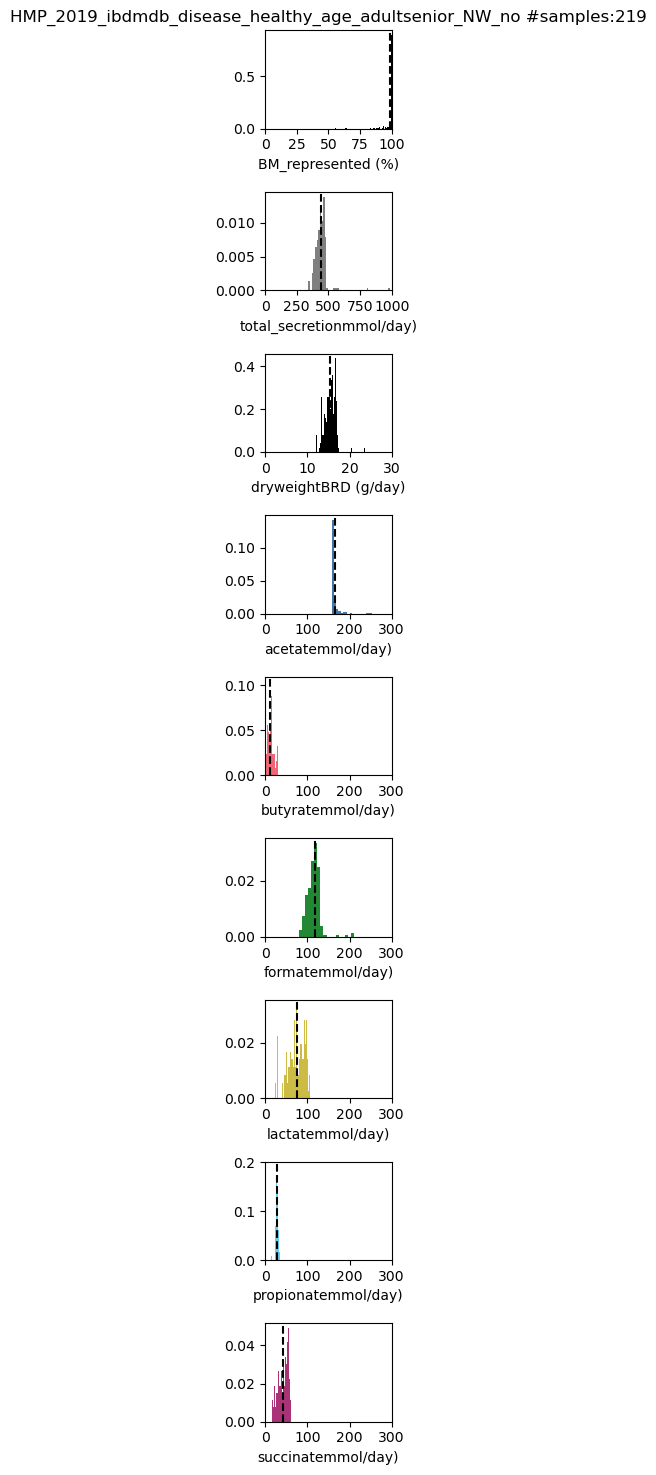

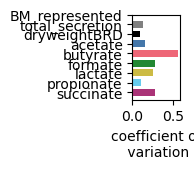

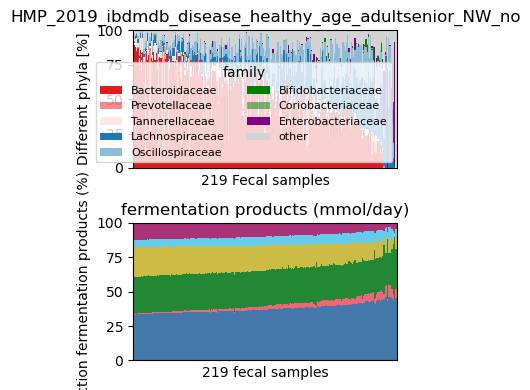

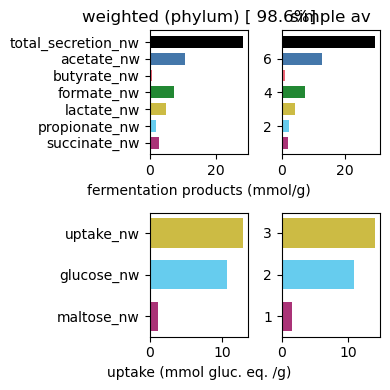

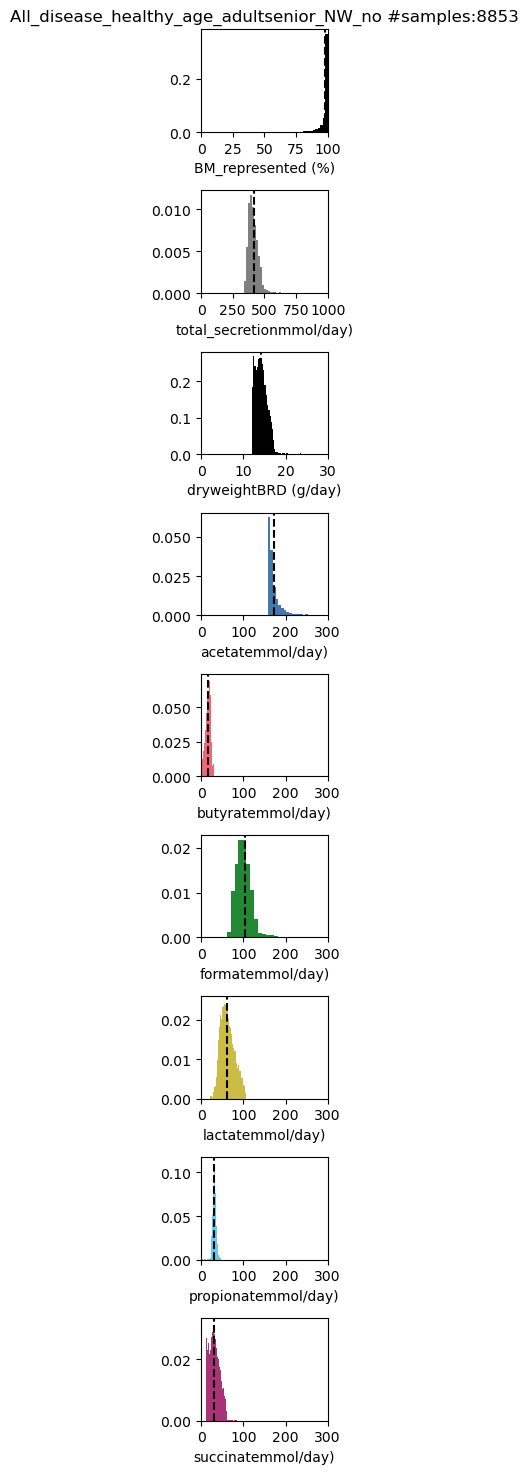

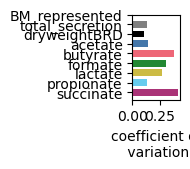

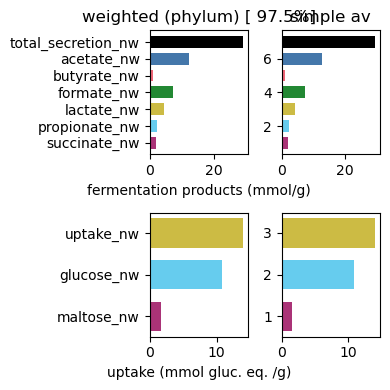

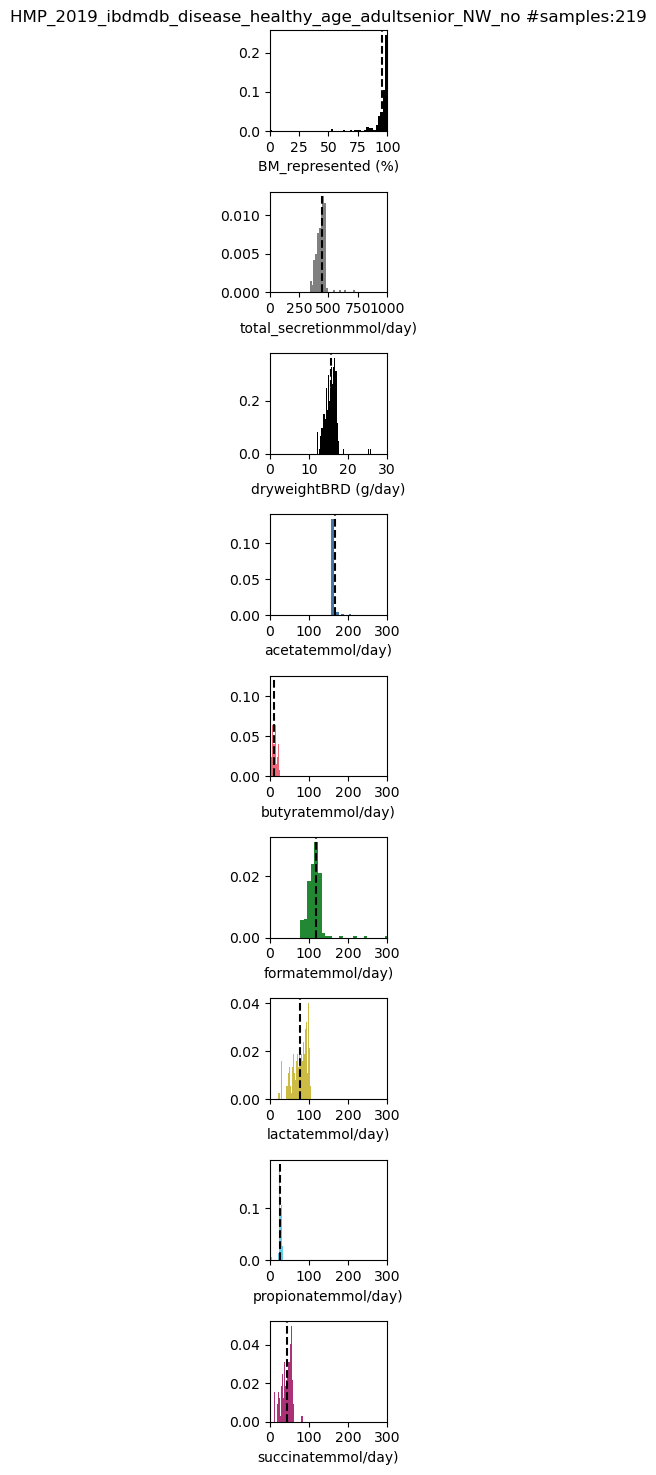

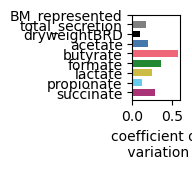

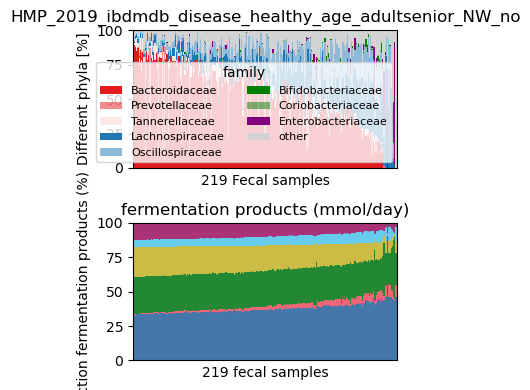

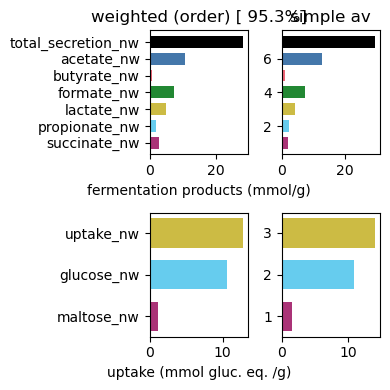

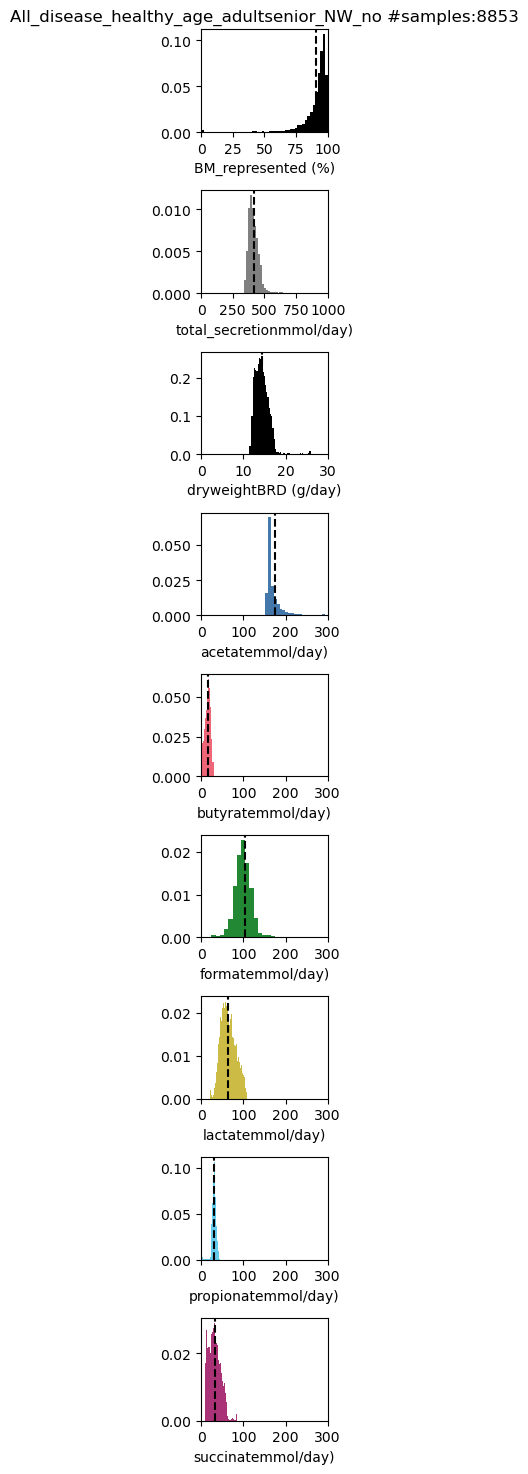

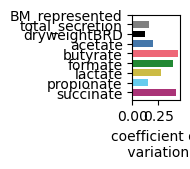

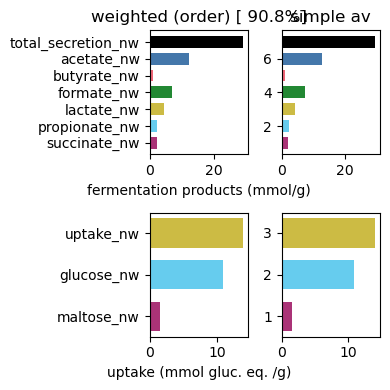

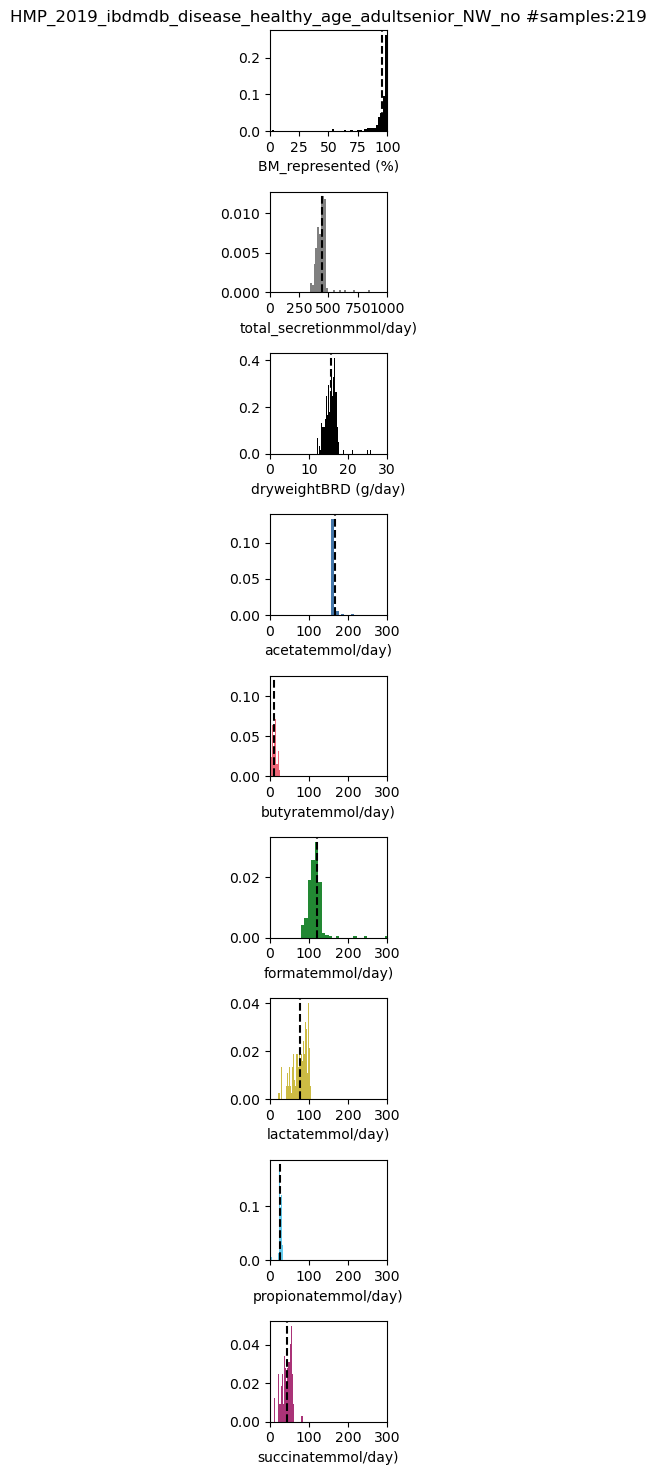

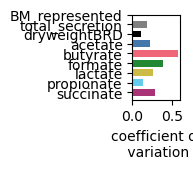

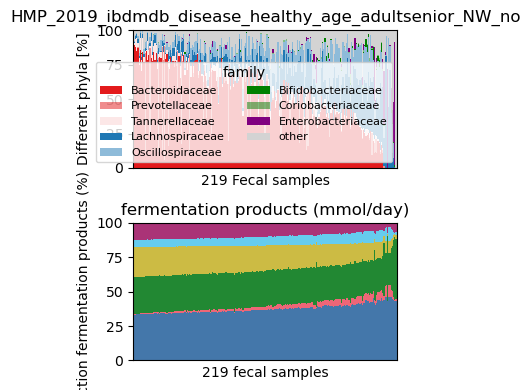

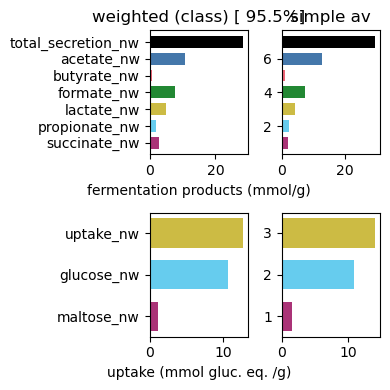

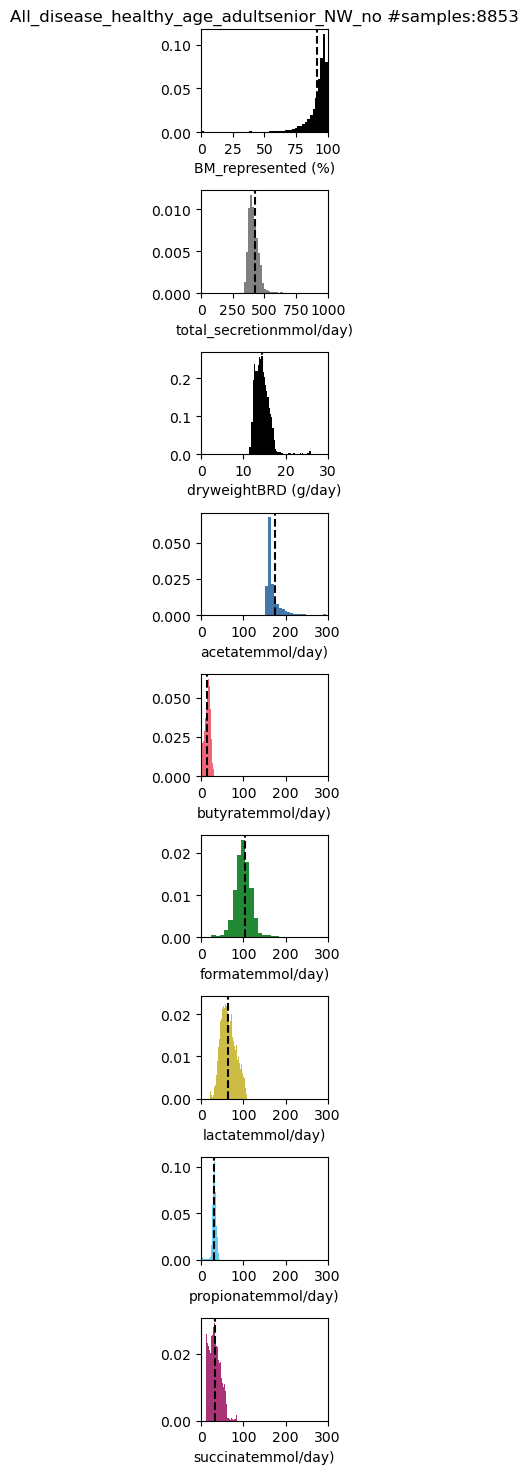

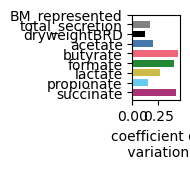

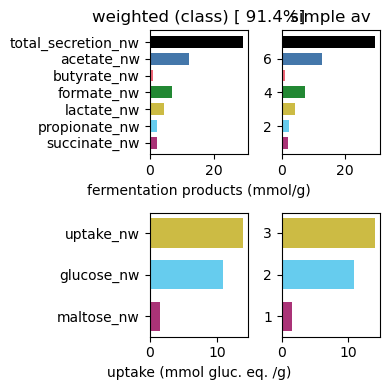

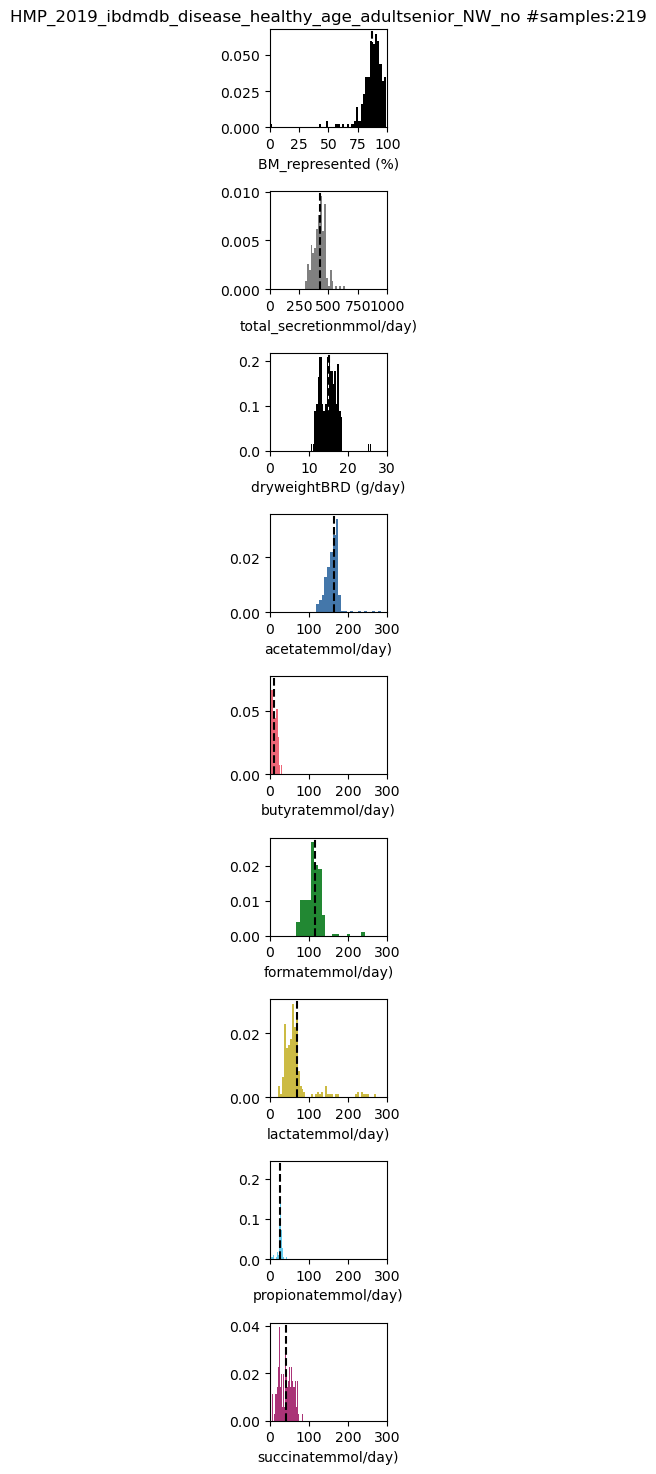

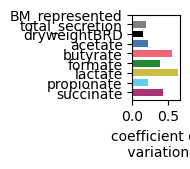

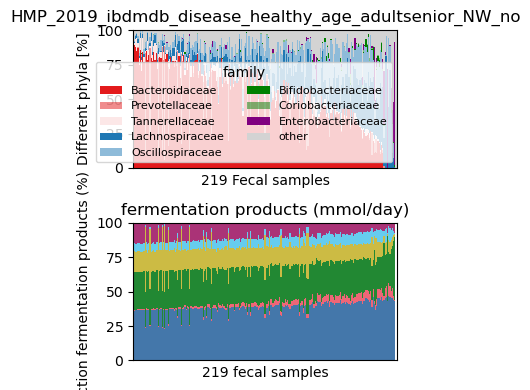

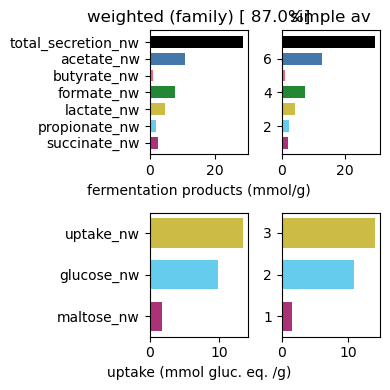

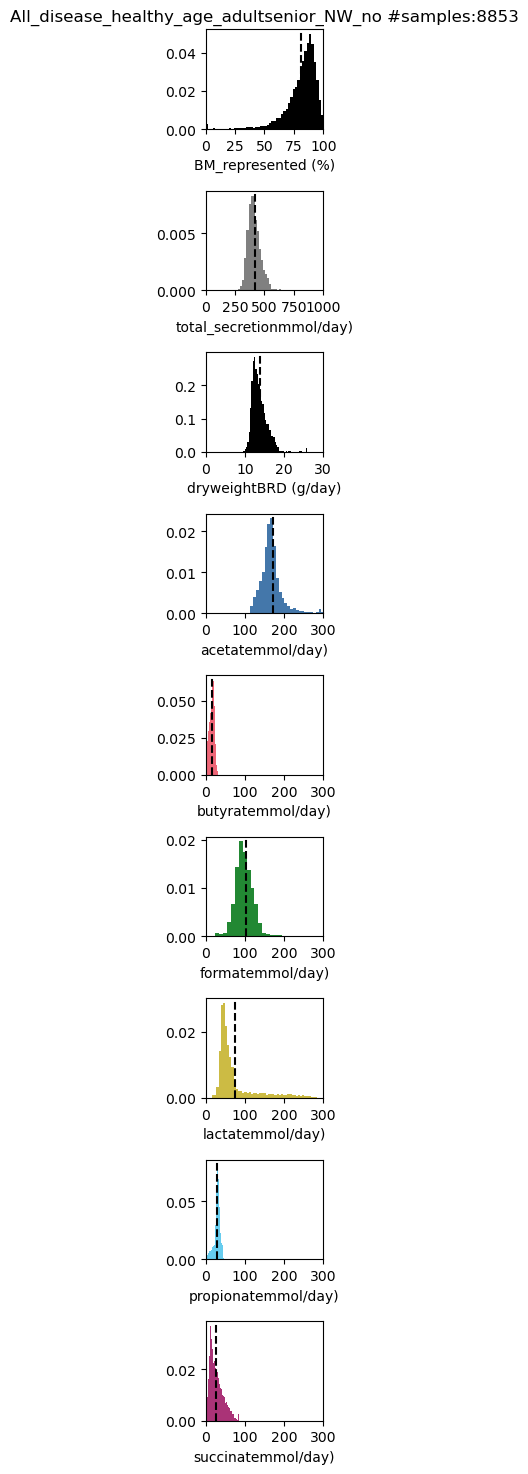

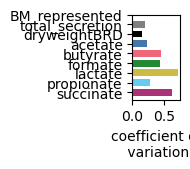

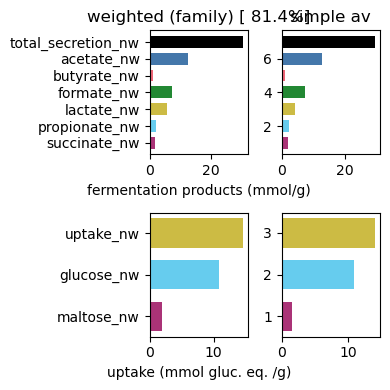

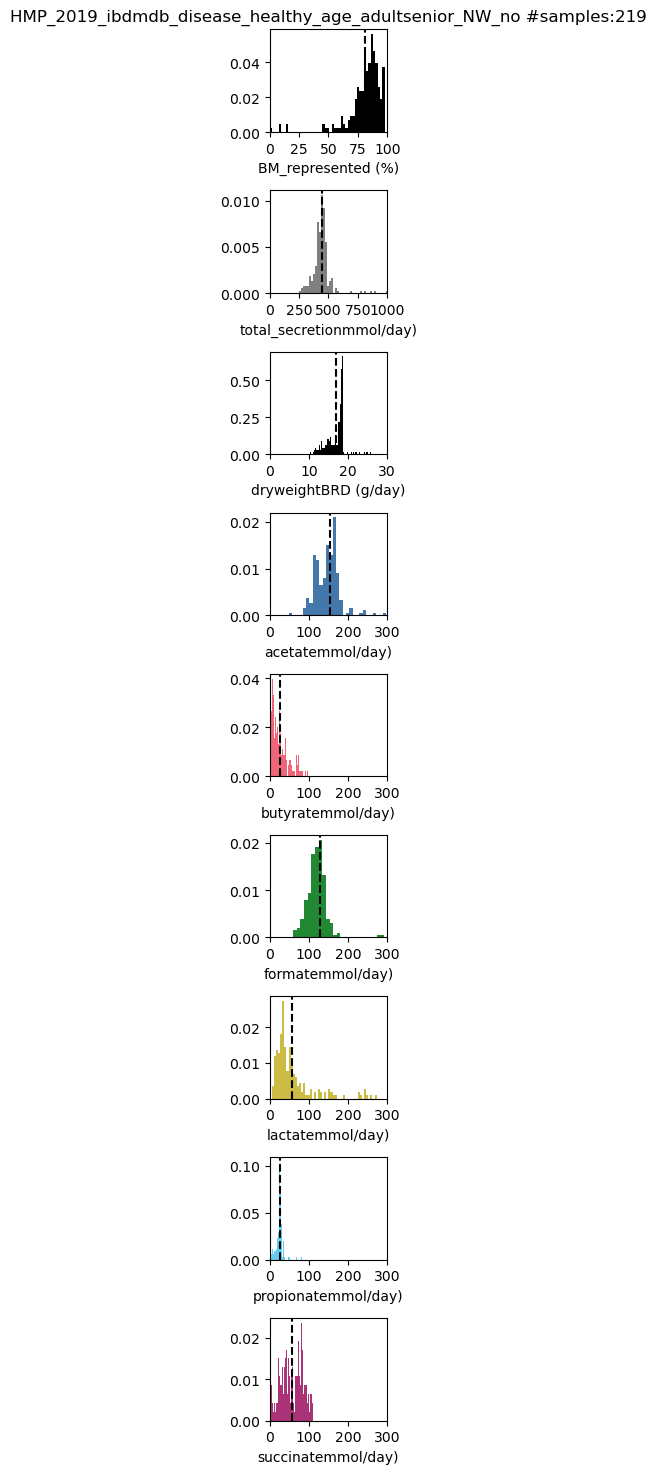

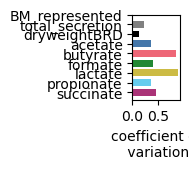

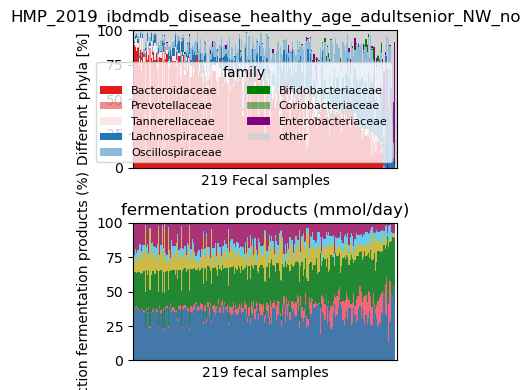

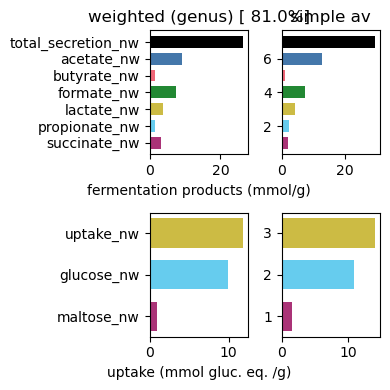

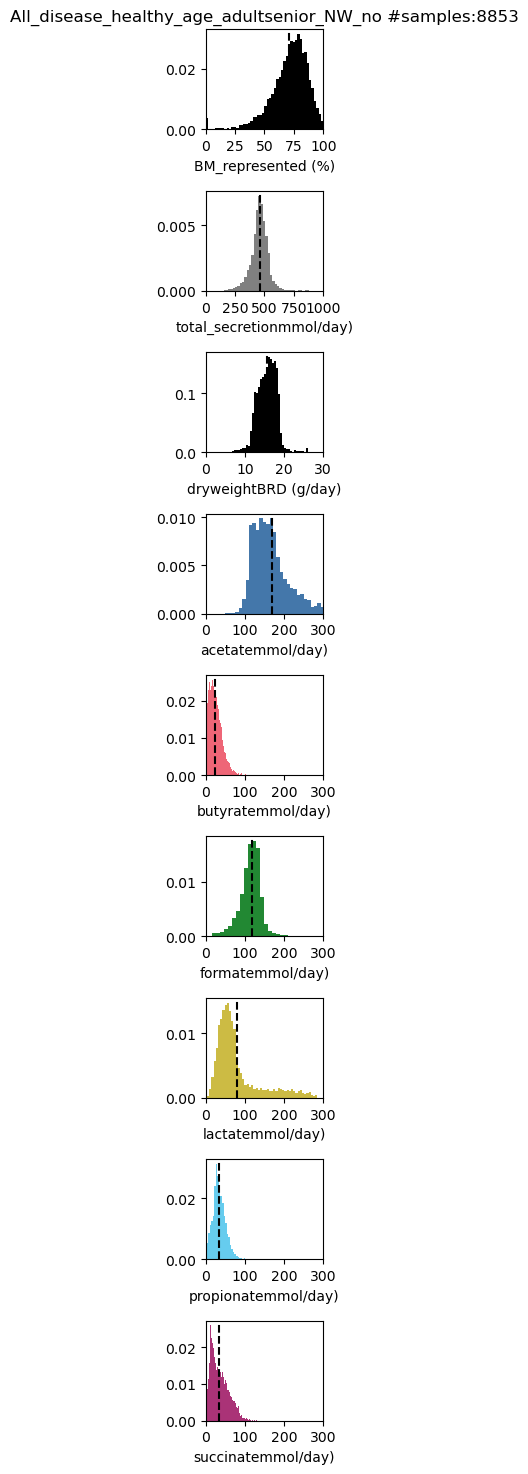

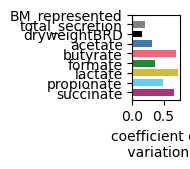

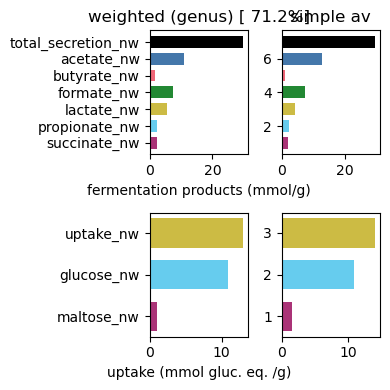

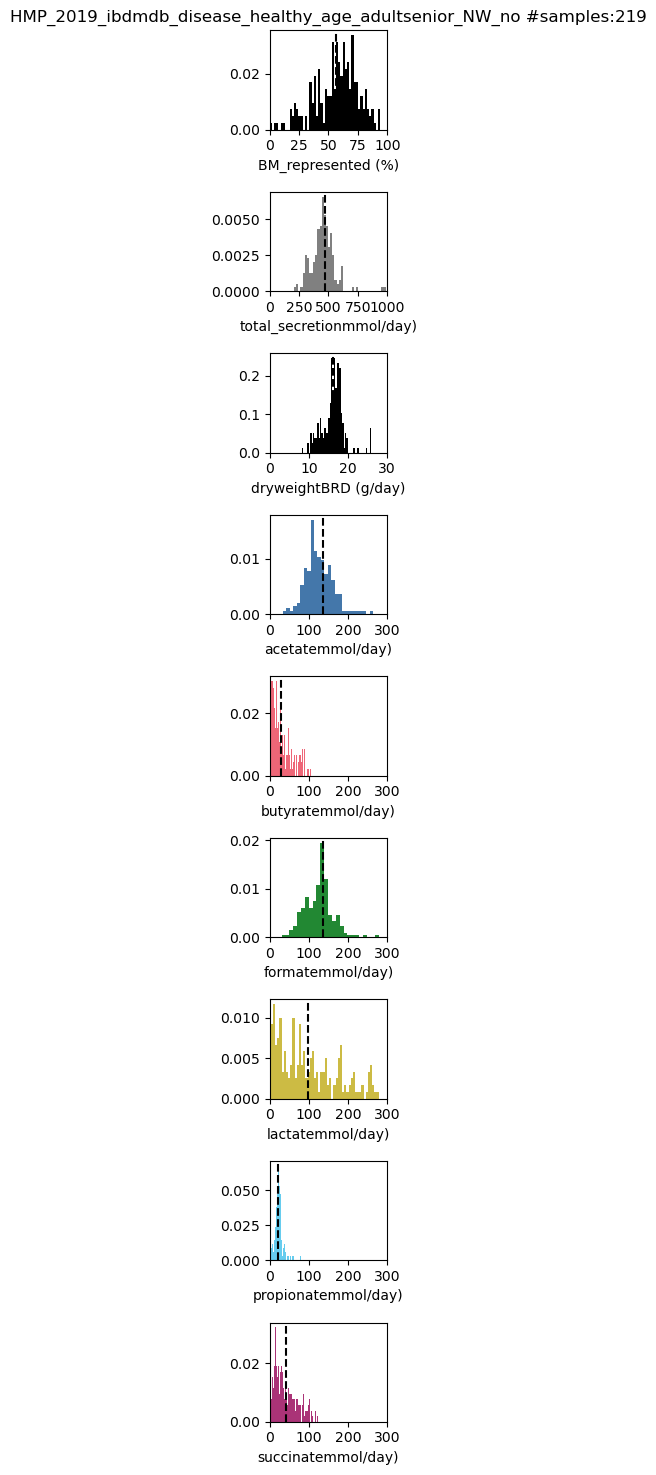

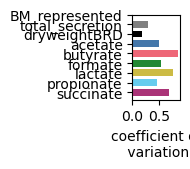

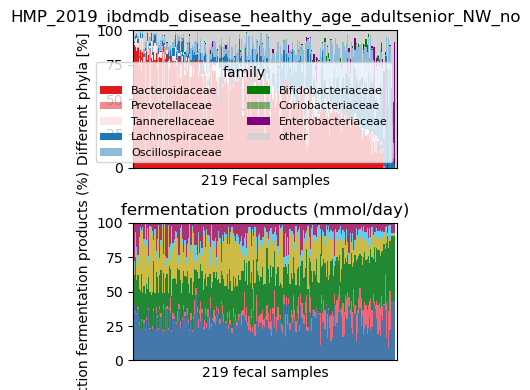

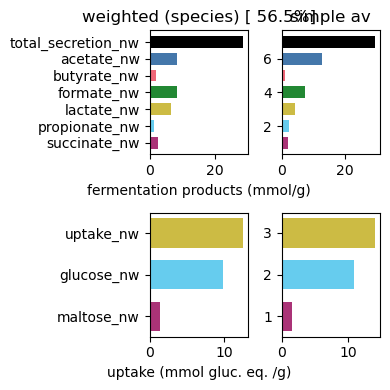

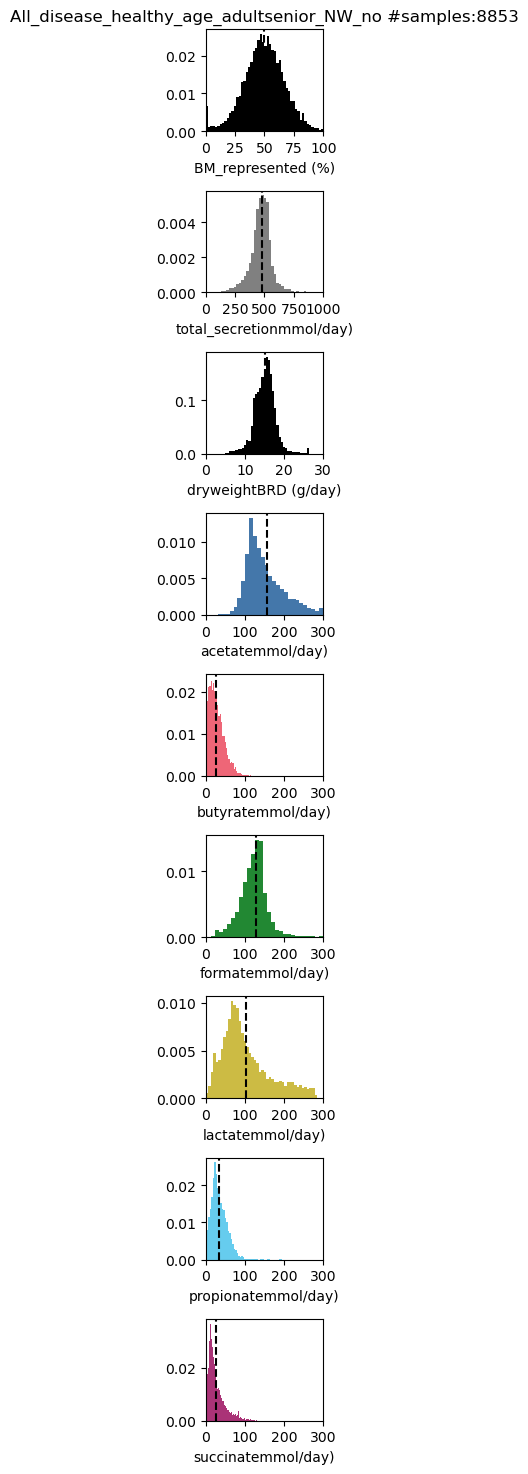

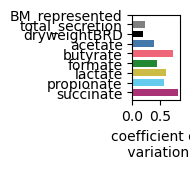

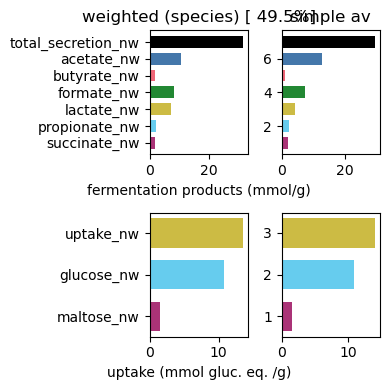

In [4]:
# Select different samples and plot distributions

#taxlevelselect="family"
#taxlevelselect="genus"
#taxlevelselect="species"
#taxlevelselect="phylum"
taxlevelselectlist=["phylum","order","class","family","genus","species"]
#taxlevelselectlist=["genus"]


#taxlevelselectlist=["genus"]
for taxlevelselect in taxlevelselectlist:
    
    display(colnames['age_category'].unique())
    display(colnames['non_westernized'].unique())
    display(colnames['disease'].unique())
    
    #study_name_l=["All"]
    #disease_l=["All"] #if  None, all health properties will be included
    #age_category_l=["All"]*len(study_name_l)
    #non_westernized_l=["All"]*len(study_name_l)
    
    #different IBD studies
    #study_name_l=["HallAB_2017","HallAB_2017","HMP_2019_ibdmdb","HMP_2019_ibdmdb","IjazUZ_2017","IjazUZ_2017","NielsenHB_2014","NielsenHB_2014","LiJ_2014","LiJ_2014","VilaAV_2018"]
    #disease_l=["healthy","IBD"]*5+["IBD"] #if  None, all health properties will be included
    #age_category_l=["All"]*len(study_name_l)
    #non_westernized_l=["All"]*len(study_name_l)
    
    #western vs non-wester
    #study_name_l=["All"]*2
    #disease_l=["All"]*len(study_name_l)#if  None, all health properties will be included
    #age_category_l=["All"]*len(study_name_l)
    #non_westernized_l=["yes","no"]
    
    #different IBD studies
    study_name_l=["HMP_2019_ibdmdb","All"]#,"AsnicarF_2021","LifeLinesDeep_2016",]
    disease_l=["healthy","healthy","healthy","healthy"]
    age_category_l=["adultsenior"]*len(study_name_l)
    non_westernized_l=["no"]*len(study_name_l)
    
    
    #crc
    #study_name_l=["GuptaA_2019","GuptaA_2019","HanniganGD_2017","HanniganGD_2017","ThomasAM_2018b","ThomasAM_2018b","ThomasAM_2019_c","ThomasAM_2019_c","VogtmannE_2016","VogtmannE_2016","WirbelJ_2018","WirbelJ_2018"]
    #study_name_l=study_name_l+["YachidaS_2019","YachidaS_2019","YuJ_2015","YuJ_2015","ZellerG_2014","ZellerG_2014"]
    #disease_l=["healthy","CRC"]*int(len(study_name_l)/2) #if  None, all health properties will be included
    #age_category_l=["All"]*len(study_name_l)
    #non_westernized_l=["All"]*len(study_name_l)
    
    results=[]
    results_taxlevel=[]
    name_conditionlist=[]
    studycountc=-1
    for study_name in study_name_l:
        print(study_name)
        studycountc=studycountc+1
        #select samples belonging to specific study / metadata
        select=colnames.loc[(colnames['body_site']=='stool')]
        if  study_name=="All":
                            pass
        else:
            select=select.loc[select["study_name"]==study_name]            
        #health condition
        disease=disease_l[studycountc]
        if disease=="All":
                pass
        else:
            print(disease)
            select=select.loc[select["disease"]==disease]
            print(select.shape)
        age_category=age_category_l[studycountc]
        if age_category=="All":
                pass
        elif age_category=="adultsenior":
            select=select.loc[(select["age_category"]=="adult") | (select["age_category"]=="senior")]
        else:
            select=select.loc[select["age_category"]==age_category]
        
        non_westernized=non_westernized_l[studycountc]
        if non_westernized=="All":
                pass
        else:
            select=select.loc[select["non_westernized"]==non_westernized]
                
        #add additional selection conditions here
        #antibiotics_current_use
        #study_condition
        #disease
        #age
        #infant_age
        #age_category newborn', 'child', 'adult', 'schoolage', 'senior
        #gender
        #country
        #non_westernized no,yes
        #pregnant 
        #lactating
        #BMI
        
        #....there are a lot more characteristics mentioned in the metadata table
        if select.shape[0]==0:
            print("error: no samples found")
            error
    
        conditionname=study_name+"_disease_"+disease+"_age_"+age_category+"_NW_"+non_westernized
        #conditionname=conditionname.replace("/","_")
        print(conditionname)
        name_conditionlist.append(conditionname)
        results.append([])
        results_taxlevel.append([])
        ##### no go through different plots
        
        select_samples=select["sample"].tolist()
        number_samples=len(select_samples)
        
        #select data and sort (for phyla distribution plots)
        select_data=average_uptake_secretion.loc[select_samples]#.dropna(how="any")
        select_data.sort_values(by=['phylumlevel_Bacteroidetes'],inplace=True,ascending=False)
    
        #### save average as JSON file
        #average to dict
        
        dict_out=select_data.mean(axis=0).to_dict()
        with open("data_analysisresults/average_excretion/selectedsamples_"+conditionname+"_"+taxlevelselect+".json", 'w') as fp:
            json.dump(dict_out, fp)
        
        quantities_to_plot=["BM_represented","total_secretion","dryweightBRD"]+sublist_secretion
        colorlistcc=["k","gray","k"]+sublist_color_secretion
    
    
        #quantities_to_plot_all=["BM_represented","total_secretion","dryweightBRD","uptake"]+sublist
        quantities_to_plot_all=["BM_represented","total_secretion","dryweightBRD","uptake"]+sublist
    
        quantities_to_plot_all=quantities_to_plot_all+['uptake_nw','total_secretion_nw','glucose_nw','maltose_nw','acetate_nw','butyrate_nw','formate_nw','lactate_nw','propionate_nw','succinate_nw']
        #set labels for quantities
        labellist=[]
        for Q in quantities_to_plot:
            if Q in ["BM_represented"]:
                labellist.append(Q+" (%)")
            elif Q in ["dryweightBRD"]:
                labellist.append(Q+" (g/day)")
            else:
                labellist.append(Q+"mmol/day)")    
        #set limits for quantities
        limmaxlist=[100,1000,30]+[300]*len(sublist_secretion)
        tickslist=[[0,25,50,75,100],[0,250,500,750,1000],[0,10,20,30]]+[[0,100,200,300]]*6
        
        print(tickslist)
        
        ###########
        #plot distributions of all fermentation products (and total secretion and weight)
        ###########
        fig, ax=plt.subplots(len(quantities_to_plot),figsize=(2,3*3.3)) #first column y, second colum x
        ax[0].set_title(conditionname+" #samples:"+str(number_samples))
        
        distributionprob=pd.DataFrame()
        sc=-1
        for sub in quantities_to_plot_all:
            print(sub[-3:])
            sc=sc+1
            taxleveldata=None
            curdata_taxlevel=[]
            if sub in ["dryweightBRD"]: 
                taxleveldata=True
                #curdata=select_data[sub]
                
                for taxlevel in taxlevels:
                    curdata_taxlevel.append(select_data[taxlevel+"level_"+sub])
            elif sub in  ["BM_represented"]: 
                #curdata=select_data[sub]
                taxleveldata=True
                for taxlevel in taxlevels:
                    curdata_taxlevel.append(select_data[taxlevel+"level_"+sub])
            elif sub[-3:] ==  "_nw": 
                #curdata=select_data[sub]
                taxleveldata=True
                for taxlevel in taxlevels:
                    curdata_taxlevel.append(select_data[taxlevel+"level_"+sub[:-3]])
            else:
                #curdata=select_data[sub]*select_data["dryweightBRD"]
                taxleveldata=True
                for taxlevel in taxlevels:
                    curdata_taxlevel.append(select_data[taxlevel+"level_"+sub]*select_data[taxlevel+"level_dryweightBRD"])   
            
            #results[studycountc].append(curdata)
            if taxleveldata:
                results_taxlevel[studycountc].append(curdata_taxlevel)
            else:
                results_taxlevel[studycountc].append([[] for _ in range(len(taxlevels))])
            
            #print(sub)
            #print(select_data[sub].mean())
            #print(select_data["dryweightBRD"].mean())
            distributionprob.at[sub,"mean"]=curdata_taxlevel[taxlevels.index(taxlevelselect)].mean()
            distributionprob.at[sub,"std"]=curdata_taxlevel[taxlevels.index(taxlevelselect)].std()
            distributionprob.at[sub,"CV"]=distributionprob.at[sub,"std"]/distributionprob.at[sub,"mean"]
    
        sc=-1
        for sub in quantities_to_plot:
            sc=sc+1


            taxleveldata=None
            curdata_taxlevel=[]
            if sub in ["dryweightBRD"]: 
                taxleveldata=True
                #curdata=select_data[sub]
                
                for taxlevel in taxlevels:
                    curdata_taxlevel.append(select_data[taxlevel+"level_"+sub])
            elif sub in  ["BM_represented"]: 
                #curdata=select_data[sub]
                taxleveldata=True
                for taxlevel in taxlevels:
                    curdata_taxlevel.append(select_data[taxlevel+"level_"+sub])
            elif sub[-3:] ==  "_nw": 
                #curdata=select_data[sub]
                taxleveldata=True
                for taxlevel in taxlevels:
                    curdata_taxlevel.append(select_data[taxlevel+"level_"+sub[:-3]])
            else:
                #curdata=select_data[sub]*select_data["dryweightBRD"]
                taxleveldata=True
                for taxlevel in taxlevels:
                    curdata_taxlevel.append(select_data[taxlevel+"level_"+sub]*select_data[taxlevel+"level_dryweightBRD"])   
            
            ax[sc].set_xlim(0,limmaxlist[sc])
                #ax[sc].set_xlim(0,700)
            if sub in ["dryweightBRD","BM_represented"]:
                bins=30
            else:
                bins=np.linspace(0,450,30)
            ax[sc].hist(curdata_taxlevel[taxlevels.index(taxlevelselect)],color=colorlistcc[sc],alpha=1,density=True,bins=50)
            ax[sc].axvline(distributionprob.at[sub,"mean"],ls='--',c='k')
            
            ax[sc].set_xlabel(labellist[sc])
            ax[sc].set_xticks(tickslist[sc])
            
            #ax[sc].text(0.72,0.8,"CV="+str(round(distributionprob.at[sub,"CV"],2)),c='k',transform=ax[sc].transAxes)
           
    
        fig.tight_layout()
        fig.savefig("plot_output_figure3/distribution_microbiomesamples"+conditionname+"_"+taxlevelselect+"level.pdf")
    
        fig.set_size_inches(2.15,4.5*3.3)
        fig.tight_layout()
        fig.savefig("plot_output_figure3/distribution_microbiomesamples"+conditionname+"_"+taxlevelselect+"level_bigger.pdf")
    
        ###########
        #plot coefficient of variation and boxplots showing variation of secretion
        ###########
        colorlistcc2=sublist_color_secretion[::-1]+["gray"]
        fig2,ax2=plt.subplots(1,1,figsize=(2.0,1.8))
        sc=-1
        list_box=[]
        colorlistcc2=[]
        
        ax2.set_xlabel("coefficient of\n variation")
        print(quantities_to_plot)
        for sub in quantities_to_plot[1:][::-1]:
            sc=sc+1
            ax2.barh(sc+1,distributionprob.at[sub,"CV"],color=colorlistcc[::-1][sc],height=0.7)
        ax2.set_yticks(range(1,len(quantities_to_plot)+1))
        ax2.set_yticklabels(quantities_to_plot[::-1])
        fig2.tight_layout()
        fig2.savefig("plot_output_figure3/barout"+conditionname+"_"+taxlevelselect+"level.pdf")
    
    
    
        
        if number_samples>5000:
            print("no pyla plots for more than 5000 samples")
        else:
            ###########################
            #### plot phyla abundance
            ###########################
            fig3, ax3=plt.subplots(2,1,figsize=(3.5,(2)*2)) #first column y, second colum x
    
            ax3[0].set_xlabel(str(number_samples)+" Fecal samples")
            ax3[0].set_ylabel("Different phyla [%]")
            ax3[0].set_ylim(0,100)
            ax3[0].set_xlim(0,number_samples)
            ax3[0].set_xticks([])
            ax3[0].set_title(conditionname)
            samplecount=-1
            
            familys=["Bacteroidaceae","Prevotellaceae","Tannerellaceae","Lachnospiraceae","Oscillospiraceae","Bifidobacteriaceae","Coriobacteriaceae","Enterobacteriaceae"]
            #genusl=["Phocaeicola","Bacteroides","Prevotella","Parabacteroides"]
            #colors_phyla=['#e31a1c']*4
            #alphal=[1,0.76,0.5,0.3]
            #genusl=genusl+["Lachnospiraceae_NA","Roseburia","Faecalibacterium","Ruminococcus"]
            #colors_phyla=colors_phyla+["#1f78b4"]*4
            
            #alphal=alphal+[1,0.76,0.5,0.3]
            #genusl=genusl+["Bifidobacterium","Collinsella","Escherichia"]
            #colors_phyla=colors_phyla+["#4daf4a"]*2
            #colors_phyla=colors_phyla+["#984ea3"]
            #alphal=alphal+[1,0.5,1]
            
            alphal=[1,0.5,0.1,1,0.5,1,0.5,1]
            colors_phyla=['#e31a1c','#e31a1c','#e31a1c','#1f78b4','#1f78b4','green','green','purple']
            #changed color slightly to be able to change it via illustrator later if wanted
            #colors_phyla=['#e31a1c','#e31a1d','#e31a1e','#1f78b4','#1f78b5','#ffb600','#ffb601','#33a02c']
            #colors_phyla=['#e41a1c','#e41a1d','#e41a1e','#377eb8','#377eb9','#4daf4a','#4daf4a','#984ea3']#,'#ff7f00']
            
            for sample in select_data.index:
                samplecount=samplecount+1
                bar_width = 1
                y_offset = 0
                #colors_phyla=['#e31a1c','#1f78b4','#b2df8a','#33a02c','#fb9a99','#a6cee3','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
                pc=-1
                
                for p in familys: #genusl: #['Bacteroidetes', 'Firmicutes', 'Actinobacteria', 'Proteobacteria']:
                    
                    if samplecount==0:
                        labelc=p
                    else:
                        labelc=None
                    pc=pc+1
                    #display(select_data.columns)
                    #print(p)
                    #p_ab=select_data.at[sample,"phylumlevel_"+p]
                    p_ab=select_data.at[sample,"familylevel_"+p]
                    
                
                    #phyla_abundance[samplecount,pc]=p_ab
                    ax3[0].bar(samplecount, p_ab, bar_width, bottom=y_offset,alpha=alphal[pc], color=colors_phyla[pc],edgecolor = "none",label=labelc)
                    y_offset = y_offset + p_ab
                #add color for other fila
                if samplecount==2:
                    ax3[0].bar(samplecount, 100-p_ab,bar_width, bottom=y_offset,alpha=alphal[pc], color="lightgray",edgecolor = "none",label="other")
                else:
                    ax3[0].bar(samplecount, 100-p_ab,bar_width, bottom=y_offset,alpha=alphal[pc], color="lightgray",edgecolor = "none")
            ax3[0].legend(title="family",ncol=2,fontsize=8)
               
            ###########################
            #### plot secretion
            ###########################    
            ax3[1].set_xlabel(str(number_samples)+" fecal samples")
            ax3[1].set_ylabel("fraction fermentation products (%)")
            ax3[1].set_ylim(0,100)
            ax3[1].set_xlim(0,number_samples)
            ax3[1].set_xticks([])
            ax3[1].set_title("fermentation products (mmol/day)")
            
            samplecount=-1
            for sample in select_data.index:
                samplecount=samplecount+1
                bar_width = 1
                y_offset = 0
    
                normalization=0
                sc=-1
                for sub in sublist_secretion:
                    sc=sc+1
                    normalization=normalization+select_data.at[sample,taxlevelselect+"level_"+sub]/100.
    
                sc=-1
                for sub in sublist_secretion:
                    sc=sc+1
                    if samplecount==0:
                        labelc=sub
                    else:
                        labelc=None
    
                    cursec=select_data.at[sample,taxlevelselect+"level_"+sub]/normalization
                    ax3[1].bar(samplecount, cursec, bar_width, bottom=y_offset, color=sublist_color_secretion[sc],edgecolor = "none",label=labelc)
                    y_offset = y_offset + cursec
            
            fig3.tight_layout()
            fig3.savefig("plot_output_figure3/phylavariation"+conditionname+"_"+taxlevelselect+"level.pdf")
        
            
        ###########
        #plot weighted average values compared with all characterized strains
        ###########
        #colorlistcc2=sublist_color_secretion[::-1]+["gray"]
        fig4,ax4=plt.subplots(2,2,figsize=(4,4))
        sc=-1
        list_box=[]
        colorlistcc2=[]
    
        #"dryweightBRD"
        quantities_to_plot2=["total_secretion_nw"]+['acetate_nw','butyrate_nw','formate_nw','lactate_nw','propionate_nw','succinate_nw']
        quantities_to_plot3=["uptake_nw","glucose_nw","maltose_nw"]
    
        #quantities_to_plot_all=quantities_to_plot_all+['glucose_nw','maltose_nw','acetate_nw','butyrate_nw','formate_nw','lactate_nw','propionate_nw','succinate_nw']
        
        print(quantities_to_plot2)
      
        #print(distributionprob)
        #klk
        
        ax4[0,0].set_xlabel("fermentation products (mmol/g)")
        for sub in quantities_to_plot2[::-1]:
            sc=sc+1
            if sub in ["glucose_nw","maltose_nw"]:
                ax4[0,0].barh(sc+1,-1*distributionprob.at[sub,"mean"],color=colorlistcc[::-1][sc],height=0.7)
                ax4[0,1].barh(sc+1,-1*avexcretion_YCA[sub[:-3]],color=colorlistcc[::-1][sc],height=0.7)
            
            else:    
                ax4[0,0].barh(sc+1,distributionprob.at[sub,"mean"],color=colorlistcc[::-1][sc],height=0.7)
                ax4[0,1].barh(sc+1,avexcretion_YCA[sub[:-3]],color=colorlistcc[::-1][sc],height=0.7)
        
        ax4[0,0].set_yticks(range(1,len(quantities_to_plot2)+1))
        ax4[0,0].set_yticklabels(quantities_to_plot2[::-1])
        
        #
        sc=-1
        list_box=[]
        colorlistcc2=[]
        ax4[1,0].set_xlabel("uptake (mmol gluc. eq. /g)")
        for sub in quantities_to_plot3[::-1]:
            sc=sc+1
            if sub in ["glucose_nw","maltose_nw"]:
                try:
                    ax4[1,0].barh(sc+1,-1*distributionprob.at[sub,"mean"],color=colorlistcc[::-1][sc],height=0.7)
                    ax4[1,1].barh(sc+1,-1*avexcretion_YCA[sub[:-3]],color=colorlistcc[::-1][sc],height=0.7)
                
                except:
                    pass
            else:    
                ax4[1,0].barh(sc+1,distributionprob.at[sub,"mean"],color=colorlistcc[::-1][sc],height=0.7)
                if sub in ["uptake_nw"]:
                    ax4[1,1].barh(sc+1,avexcretion_YCA[sub[:-3]],color=colorlistcc[::-1][sc],height=0.7)
                else:
                    ax4[1,1].barh(sc+1,-1*avexcretion_YCA[sub[:-3]],color=colorlistcc[::-1][sc],height=0.7)
                
        ax4[1,0].set_yticks(range(1,len(quantities_to_plot3)+1))
        ax4[1,0].set_yticklabels(quantities_to_plot3[::-1])
    
        ax4[0,0].set_title("weighted ("+taxlevelselect+") ["+" "+str(round(distributionprob.at["BM_represented","mean"],1))+"%]")
        ax4[0,1].set_title("simple av")
        fig4.tight_layout()
        fig4.savefig("plot_output_figure3/av_valuesbar_"+conditionname+"_"+taxlevelselect+"level.pdf")
    
        



# Plot variation across different studies

Only use this for more than one study/condition comparison

shown taxonomic level: genus


/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


#AA3377
BM_represented
total_secretion
dryweightBRD
acetate
butyrate
formate
lactate
propionate
succinate


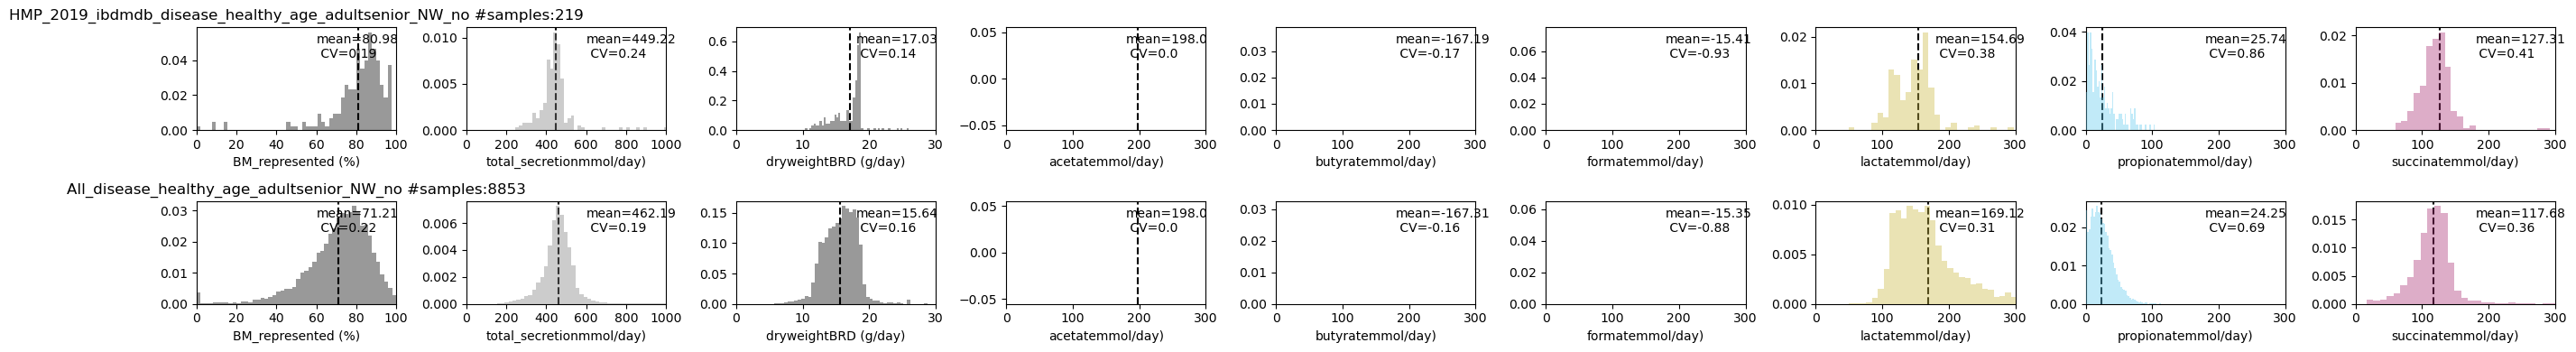

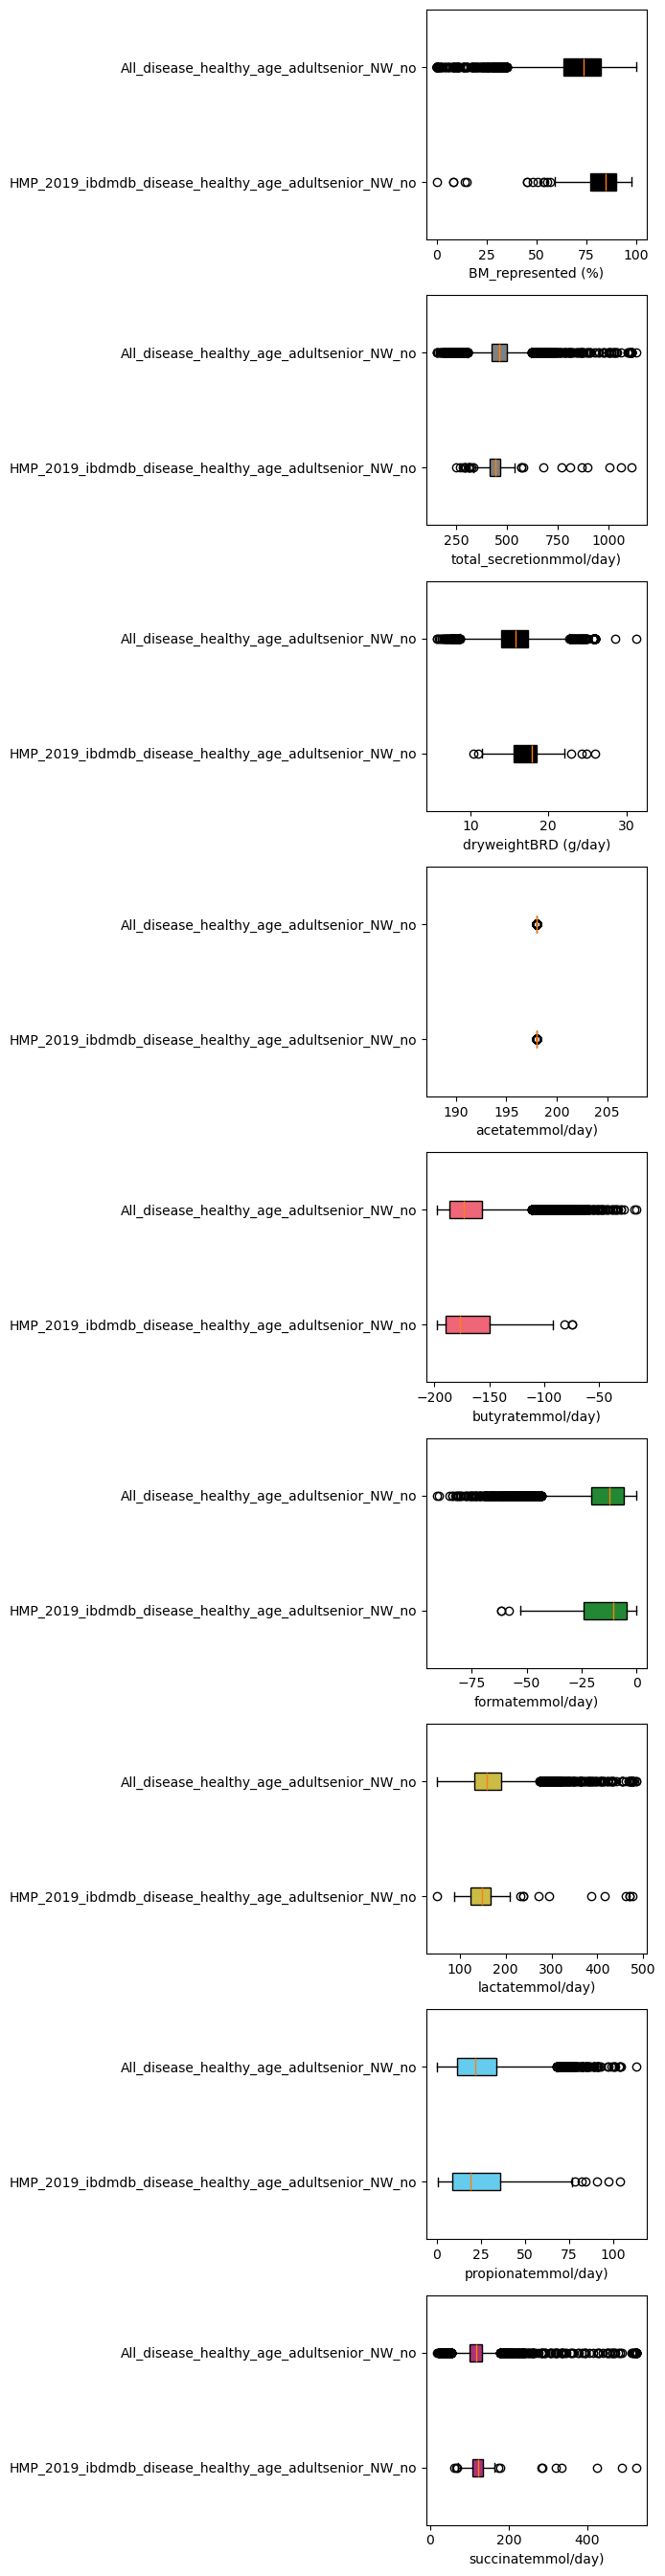

In [5]:

taxlevel_select='genus'#'genus', 'family', 'order', 'class', 'phylum']
taxlevel_select_index=taxlevels.index(taxlevel_select)
print("shown taxonomic level: "+taxlevel_select)

fig, ax=plt.subplots(len(name_conditionlist),len(quantities_to_plot),figsize=(3*len(quantities_to_plot),2*len(name_conditionlist))) #first column y, second colum x

boxplotdata=[]

iC = -1
for condition in name_conditionlist:
    iC=iC+1
    pQ = -1
    for plot_quantity in quantities_to_plot:
        pQ=pQ+1
        if iC==0:
            boxplotdata.append([])
            
        #curdata=results[iC][pQ]
        curdata_phylalevel=results_taxlevel[iC][pQ][taxlevel_select_index]
        if len(curdata_phylalevel)==0:
            plottaxonomiclevel=False
        else:
            plottaxonomiclevel=True
        
        
        mean=curdata_phylalevel.mean()
        std=curdata_phylalevel.std()
        cv=std/mean

        if pQ==0:
            ax[iC,pQ].set_title(condition+" #samples:"+str(curdata_phylalevel.shape[0]))
            colorlistcc
    
        
        
        ax[iC,pQ].text(0.6,0.7,"mean="+str(round(mean,2))+"\n CV="+str(round(cv,2)),c='k',transform=ax[iC,pQ].transAxes)
        
        if plottaxonomiclevel:
            ax[iC,pQ].hist(curdata_phylalevel,color=colorlistcc[pQ],alpha=0.4,density=True,zorder=4,bins=50)
        else:
            error
        boxplotdata[pQ].append(curdata_phylalevel.dropna().values) #remove also nan to ensure box plot works
        ax[iC,pQ].axvline(mean,ls='--',c='k')
        ax[iC,pQ].set_xlabel(labellist[pQ])
        ax[iC,pQ].set_xlim(0,limmaxlist[pQ])
    fig.tight_layout()
    fig.savefig("plot_output_figure3/distribution_microbiomesamples"+conditionname+".pdf")


#plot boxplot
fig2, ax2=plt.subplots(len(quantities_to_plot),1,figsize=(7,3*len(quantities_to_plot))) #first column y, second colum x

print(colorlistcc[pQ])
pQ = -1
for plot_quantity in quantities_to_plot:
    print(plot_quantity)
    pQ=pQ+1
    bplc=ax2[pQ].boxplot(boxplotdata[pQ],patch_artist=True,vert=False) #showfliers=False
    ax2[pQ].set_xlabel(labellist[pQ])
    #ax2[0].boxplot(list_box,patch_artist=True,vert=False,)#,"Mice (autoclaved lab coy)"])
    for patch in bplc['boxes']:
        patch.set_facecolor(colorlistcc[pQ])
    
    #labels
    ax2[pQ].set_yticks(range(1,len(name_conditionlist)+1))
    ax2[pQ].set_yticklabels(name_conditionlist)
    
fig2.tight_layout()
fig2.savefig("plot_output_figure3/distribution_microbiomesamples_boxplots_"+conditionname+".pdf")


# Plot cross correlation phyla level vs species level

shown taxonomic level: class


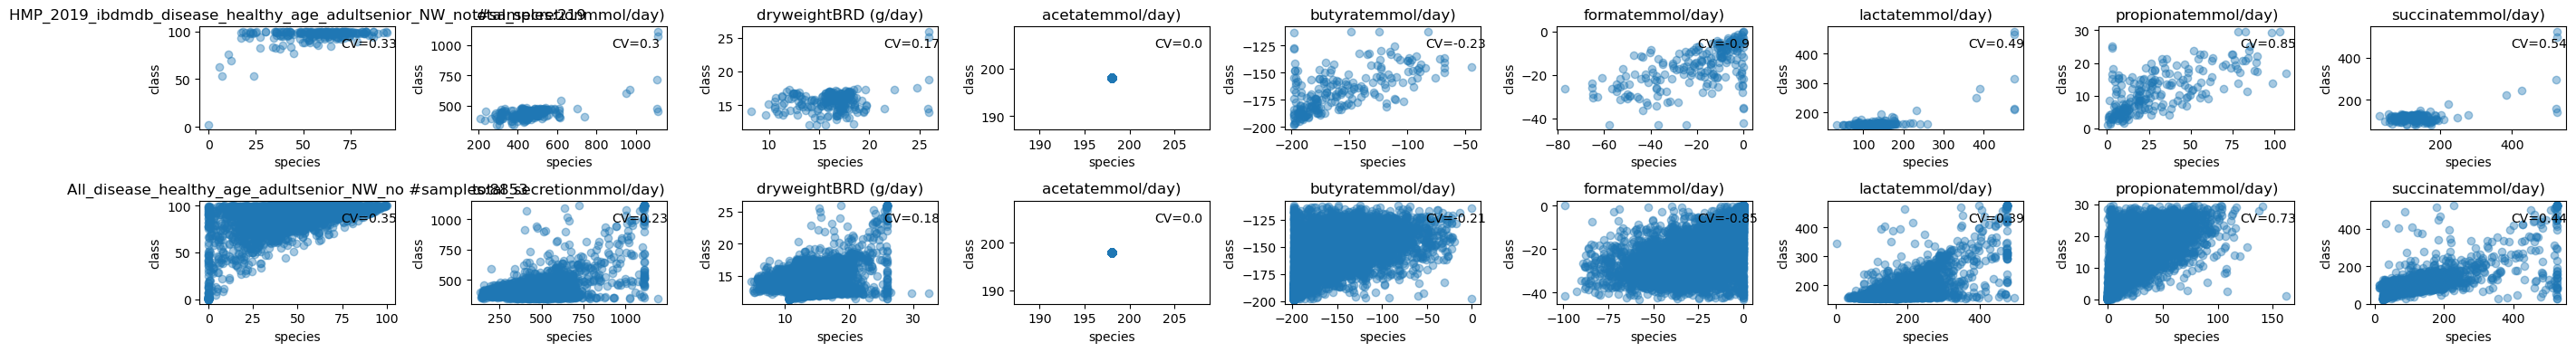

In [6]:
taxlevel_select='class'#'genus', 'family', 'order', 'class', 'phylum']
taxlevel_select_index=taxlevels.index(taxlevel_select)
print("shown taxonomic level: "+taxlevel_select)

fig, ax=plt.subplots(len(name_conditionlist),len(quantities_to_plot),figsize=(3*len(quantities_to_plot),2*len(name_conditionlist))) #first column y, second colum x
iC = -1
for condition in name_conditionlist:
    iC=iC+1
    pQ = -1
    for plot_quantity in quantities_to_plot:
        pQ=pQ+1
        curdata=results_taxlevel[iC][pQ][taxlevels.index("species")]
        curdata_phylalevel=results_taxlevel[iC][pQ][taxlevel_select_index]
        
        mean=curdata.mean()
        std=curdata.std()
        cv=std/mean

        if pQ==0:
            ax[iC,pQ].set_title(condition+" #samples:"+str(curdata.shape[0]))
            colorlistcc
        ax[iC,pQ].text(0.72,0.8,"CV="+str(round(cv,2)),c='k',transform=ax[iC,pQ].transAxes)

        try:
            ax[iC,pQ].scatter(curdata,curdata_phylalevel,alpha=0.4)
        except:
            pass
        ax[iC,pQ].set_ylabel(taxlevel_select)
        ax[iC,pQ].set_xlabel("species")
        
        if pQ != 0:
            ax[iC,pQ].set_title(labellist[pQ])
            
    fig.tight_layout()
    fig.savefig("plot_output_figure3/distribution_microbiomesamples"+conditionname+".pdf")


    
    

# Plot for one condition different taxonomic levels

/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


quant
acetate
198.0044407438247
MSM79HB6      198.004441
MSM9VZME      198.004441
MSM79HFW      198.004441
MSM6J2K4      198.004441
CSMAAEUA      198.004441
                 ...    
MSMA26BH      198.004441
CSM79HGZ      198.004441
CSM79HGV_P    198.004441
MSM9VZHF      198.004441
MSM9VZJZ             NaN
Length: 219, dtype: float64


/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/mf/9x1lv58d7zx4bvlcc_ngwkxh0000gn/T/ipykernel_67858/1872607189.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


quant
acetate
198.00444074382466
MSM79HB6      198.004441
MSM9VZME      198.004441
MSM79HFW      198.004441
MSM6J2K4      198.004441
CSMAAEUA      198.004441
                 ...    
MSMA26BH      198.004441
CSM79HGZ      198.004441
CSM79HGV_P    198.004441
MSM9VZHF      198.004441
MSM9VZJZ             NaN
Length: 219, dtype: float64


/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/mf/9x1lv58d7zx4bvlcc_ngwkxh0000gn/T/ipykernel_67858/1872607189.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


quant
acetate
198.00444074382466
MSM79HB6      198.004441
MSM9VZME      198.004441
MSM79HFW      198.004441
MSM6J2K4      198.004441
CSMAAEUA      198.004441
                 ...    
MSMA26BH      198.004441
CSM79HGZ      198.004441
CSM79HGV_P    198.004441
MSM9VZHF      198.004441
MSM9VZJZ             NaN
Length: 219, dtype: float64


/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


quant
acetate
198.00444074382466
MSM79HB6      198.004441
MSM9VZME      198.004441
MSM79HFW      198.004441
MSM6J2K4      198.004441
CSMAAEUA      198.004441
                 ...    
MSMA26BH      198.004441
CSM79HGZ      198.004441
CSM79HGV_P    198.004441
MSM9VZHF      198.004441
MSM9VZJZ      198.004441
Length: 219, dtype: float64


/var/folders/mf/9x1lv58d7zx4bvlcc_ngwkxh0000gn/T/ipykernel_67858/1872607189.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()
/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/mf/9x1lv58d7zx4bvlcc_ngwkxh0000gn/T/ipykernel_67858/1872607189.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


quant
acetate
198.00444074382466
MSM79HB6      198.004441
MSM9VZME      198.004441
MSM79HFW      198.004441
MSM6J2K4      198.004441
CSMAAEUA      198.004441
                 ...    
MSMA26BH      198.004441
CSM79HGZ      198.004441
CSM79HGV_P    198.004441
MSM9VZHF      198.004441
MSM9VZJZ      198.004441
Length: 219, dtype: float64


/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/jonascremer/miniforge3/envs/ete3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/mf/9x1lv58d7zx4bvlcc_ngwkxh0000gn/T/ipykernel_67858/1872607189.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


quant
acetate
198.00444074382466
MSM79HB6      198.004441
MSM9VZME      198.004441
MSM79HFW      198.004441
MSM6J2K4      198.004441
CSMAAEUA      198.004441
                 ...    
MSMA26BH      198.004441
CSM79HGZ      198.004441
CSM79HGV_P    198.004441
MSM9VZHF      198.004441
MSM9VZJZ      198.004441
Length: 219, dtype: float64


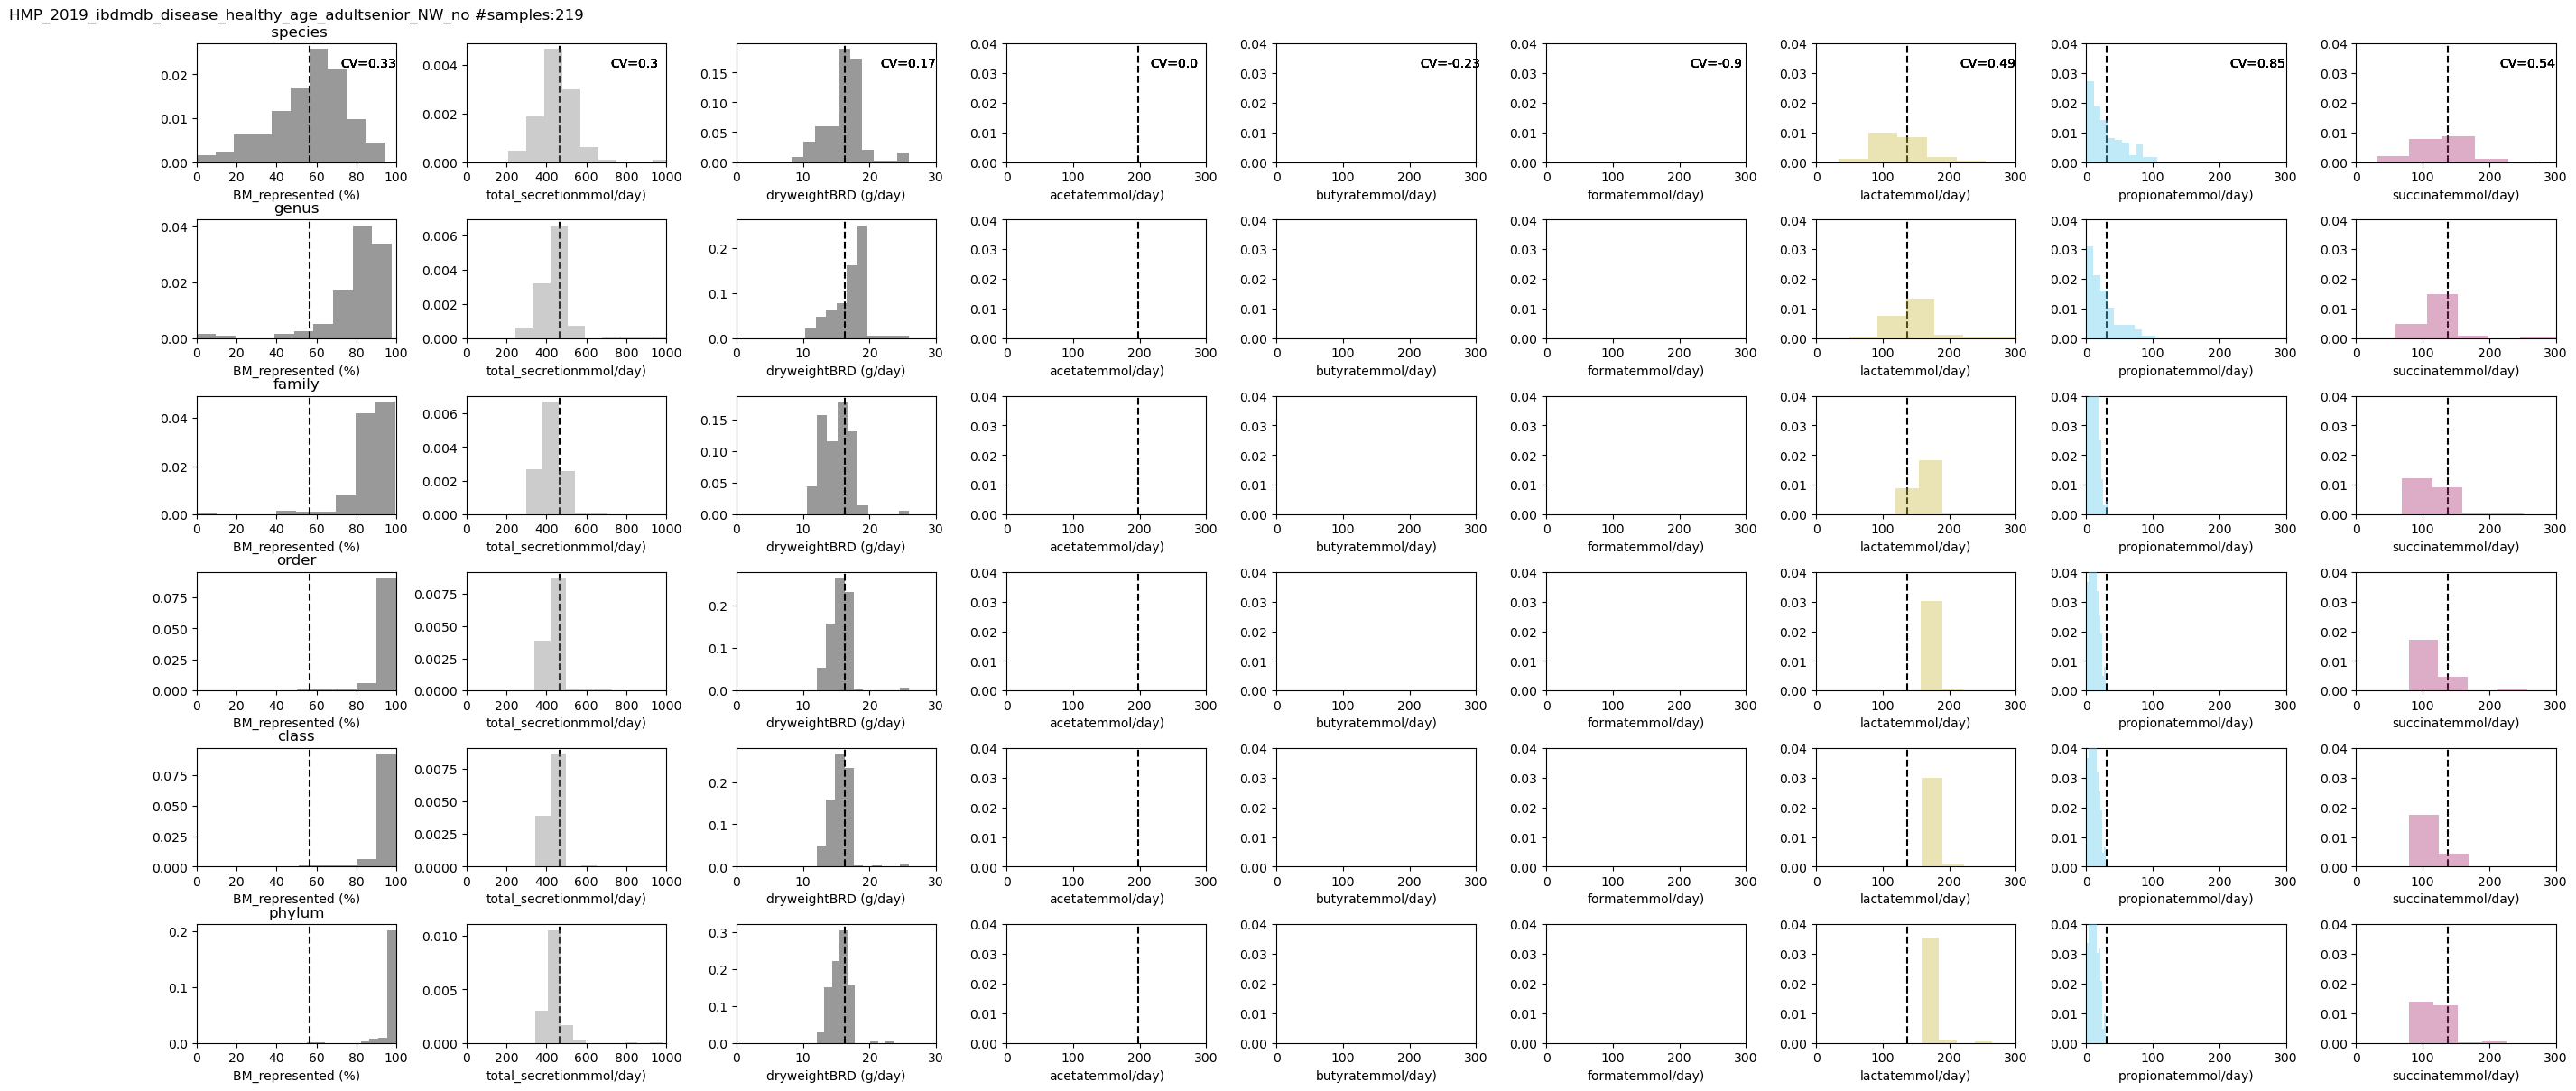

In [7]:
fig, ax=plt.subplots(len(taxlevels),len(quantities_to_plot),figsize=(3*len(quantities_to_plot),2*len(taxlevels))) #first column y, second colum x
iC = 0
condition = name_conditionlist[0] #decide for which study/selection of species analysis to plot
tL=-1
for taxlevel_select in taxlevels:
    taxlevel_select_index=taxlevels.index(taxlevel_select)
    tL=tL+1
    pQ = -1
    for plot_quantity in quantities_to_plot:
        pQ=pQ+1
        curdata=results_taxlevel[iC][pQ][taxlevels.index("species")]
        curdata_phylalevel=results_taxlevel[iC][pQ][taxlevel_select_index]
        if len(curdata_phylalevel)==0:
            plottaxonomiclevel=False
        else:
            plottaxonomiclevel=True

        mean=curdata.mean()
        std=curdata.std()
        cv=std/mean
        if pQ==0 and tL==0:
            ax[tL,pQ].set_title(condition+" #samples:"+str(curdata.shape[0])+"\n "+taxlevel_select)
        elif pQ==0:
            ax[tL,pQ].set_title(taxlevel_select)
            
        
        
        ax[tL,pQ].text(0.72,0.8,"CV="+str(round(cv,2)),c='k',transform=ax[iC,pQ].transAxes)

        if plottaxonomiclevel:
            ax[tL,pQ].hist(curdata_phylalevel,color=colorlistcc[pQ],alpha=0.4,density=True,zorder=4)
        if plot_quantity=="acetate":
            print("quant")
            print(plot_quantity)
            print(np.max(curdata_phylalevel))
            print(curdata_phylalevel)
        
        if pQ in [3,4,5,6,7,8,9,10]:
            ax[tL,pQ].set_ylim(0,0.04)
        
        ax[tL,pQ].axvline(mean,ls='--',c='k')
        ax[tL,pQ].set_xlabel(labellist[pQ])
        ax[tL,pQ].set_xlim(0,limmaxlist[pQ])            
    fig.tight_layout()
    fig.savefig("plot_output_figure3/distribution_microbiomesamples"+conditionname+".pdf")

# Compare average excretion for specific dataset with simple mean of all experimentally characterized species

After estimation of microbiota averages excretion values for different studies we compare here the values to a simple average, i.e. assuming all 16 characterized strains are equally abundance.

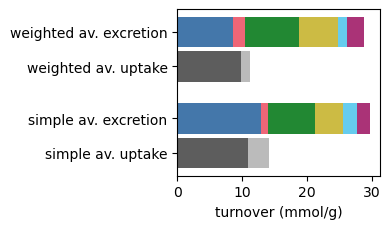

In [8]:

#decide which study to analyze
conditionlist=["selectedsamples_HMP_2019_ibdmdb_disease_healthy_age_All_NW_All_genus"]
f = open (os.path.join("data_analysisresults/average_excretion","av_YCA.json"), "r")
simple_average=json.loads(f.read())
f.close()




for condition in conditionlist:
    f = open (os.path.join("data_analysisresults/average_excretion",condition+".json"), "r")
    study_average=json.loads(f.read())
    f.close()

    maxrange_use=[0, 0, 21.91328286546662, 427.97354951182075, 32.53933894024488, 86.44828371059165, 241.13863475930566, 131.90435581431424, 676.3332648399427, 548.4887811755605, 1719.625521469051]

    #to collect data for later
    results_list=[]
    resultsall=[]

    studycountc=-1

    fig,ax=plt.subplots(1,1,figsize=(4,2.4))
    
    ax.set_xlabel("turnover (mmol/g)")
    ax.set_yticks([0.4,0.8,1.4,1.8])
    ax.set_yticklabels(["simple av. uptake","simple av. excretion","weighted av. uptake","weighted av. excretion"])
    utav=0
    utmbav=0
    exav=0
    exmbav=0
    iS=-1
    h=0.35
    for sub in sublist:
        iS=iS+1
        if sub in ["glucose"]:
            ax.barh(0.4,-1*simple_average[sub],left=utav,color=sublist_color[iS],height=h)
            utav=utav-simple_average[sub]
            
            ax.barh(1.4,-1*study_average[sub],left=utmbav,color=sublist_color[iS],height=h)
            utmbav=utmbav-study_average[sub]
        elif sub in ["maltose"]:
            ax.barh(0.4,-2*simple_average[sub],left=utav,color=sublist_color[iS],height=h)
            utav=utav-2*simple_average[sub]
            
            ax.barh(1.4,-1*study_average[sub],left=utmbav,color=sublist_color[iS],height=h)
            utmbav=utmbav-study_average[sub]
            
        else:
            ax.barh(0.8,simple_average[sub],left=exav,color=sublist_color[iS],height=h)
            exav=exav+simple_average[sub]
            
            ax.barh(1.8,study_average[sub],left=exmbav,color=sublist_color[iS],height=h)
            exmbav=exmbav+study_average[sub]
    #ax.set_yticks([1,2])
    #ax.set_yticklabels(["standard","weighted"])
    fig.tight_layout()
    fig.savefig("plot_output_figure3/comparison_average_and_weighted.pdf")